# Modelo SFR con RandomforestRegressor

ANÁLISIS EXPLORATORIO - Distribución de SFR

Dataset original: 5,688,042 galaxias
Features totales: 26

--- Estadísticas SFR ---
count    5.688042e+06
mean     6.036019e-04
std      6.771741e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.941917e+01
Name: SubhaloSFR, dtype: float64
SFR = 0: 5,670,489 (99.7%)
SFR > 0: 17,553 (0.3%)


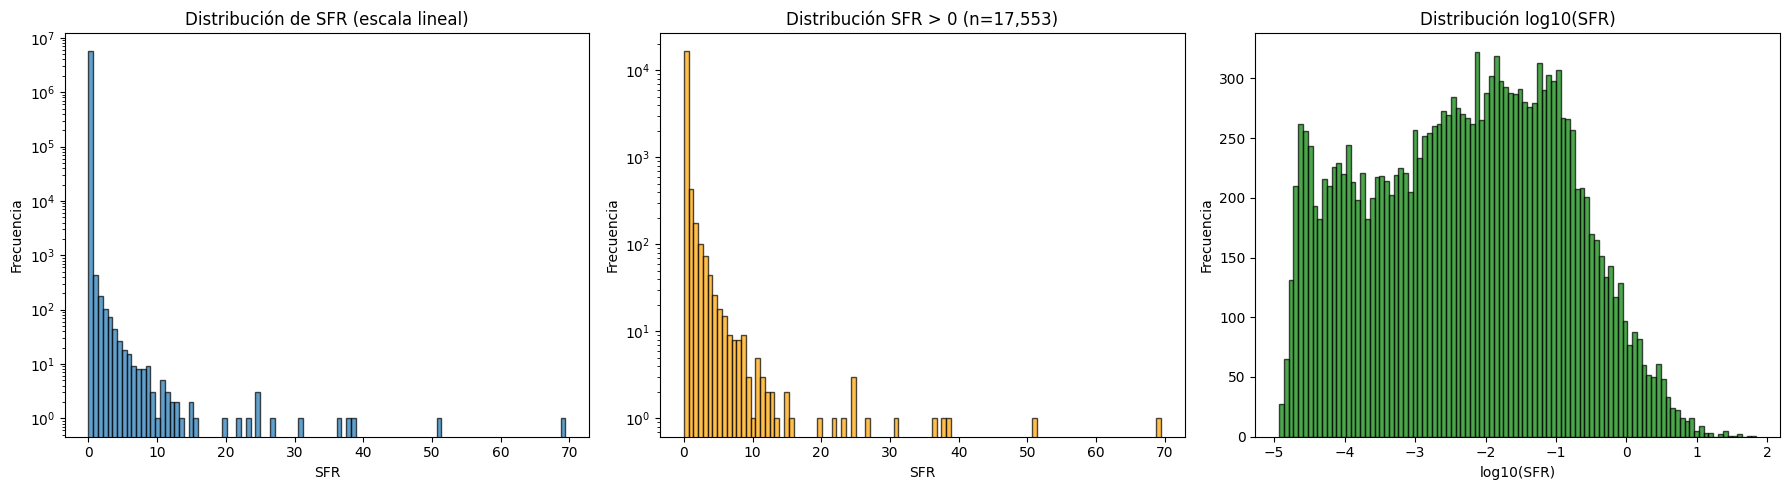


LIMPIEZA DE FEATURES - Eliminar leakage de SFR

Eliminando 3 columnas relacionadas con SFR:
  - SubhaloSFRinRad
  - SubhaloSFRinHalfRad
  - SubhaloSFRinMaxRad

⚠️  Columnas potencialmente relacionadas con formación estelar:
  - SubhaloStarMetallicity
  - SubhaloStarMetallicityHalfRad
  - SubhaloStarMetallicityMaxRad
Considera si estas features causan leakage

Shape final: (5688042, 23)

SAMPLING DEL DATASET

Opciones de sampling:
A) Solo galaxias con SFR > 0 (predecir intensidad de formación)
B) Todas las galaxias (predecir SFR incluyendo ceros)

→ Usando solo galaxias con SFR > 0: 17,553
Dataset final para regresión: 17,553
Features: 22

Skewness de SFR: 26.41
→ SFR muy sesgado, considerar transformación log
→ Aplicando log10(SFR) como target

Train: 14,042 muestras
Test:  3,511 muestras
SFR train - min: -4.9291, max: 1.8415, mean: -2.2949
SFR test  - min: -4.9180, max: 1.7103, mean: -2.2999

CONFIGURACIÓN GRID SEARCH
Combinaciones: 324

ENTRENAMIENTO
Fitting 5 folds for each of 324 

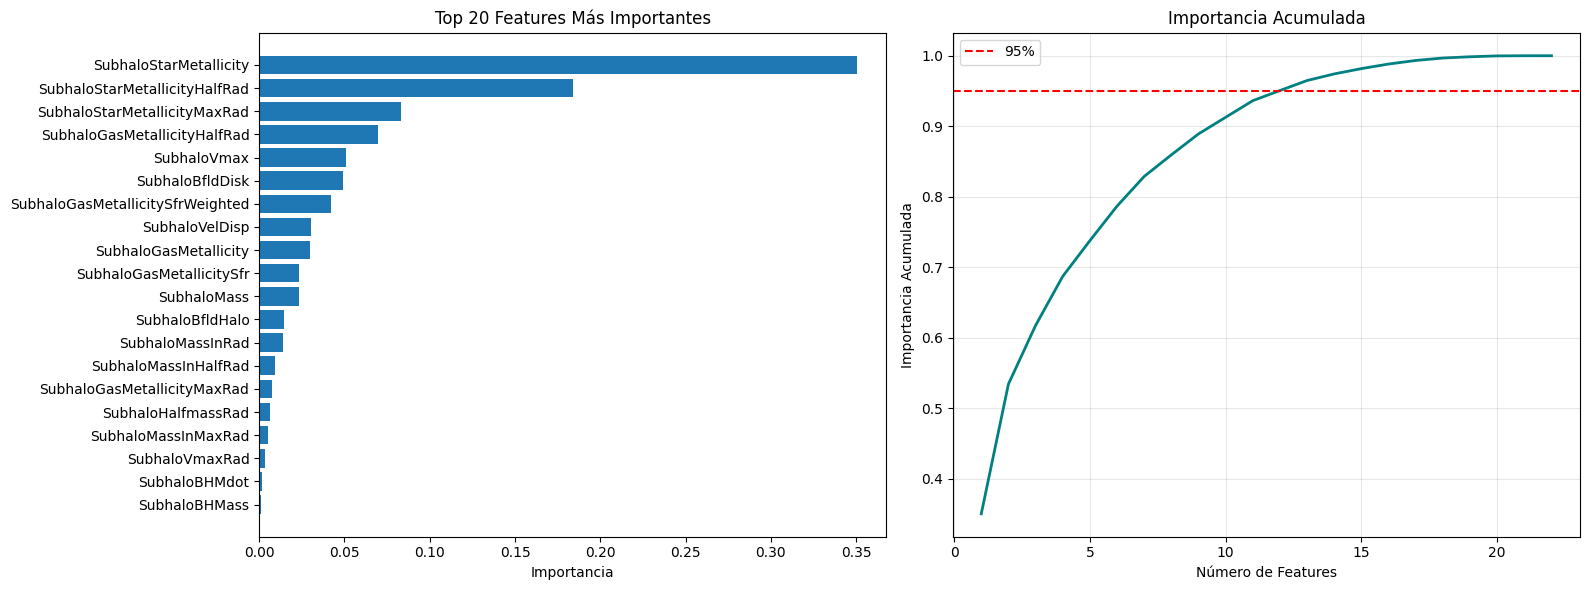


--- Top 15 Features ---
SubhaloStarMetallicity              0.350278
SubhaloStarMetallicityHalfRad       0.183918
SubhaloStarMetallicityMaxRad        0.083233
SubhaloGasMetallicityHalfRad        0.069656
SubhaloVmax                         0.050615
SubhaloBfldDisk                     0.048969
SubhaloGasMetallicitySfrWeighted    0.042113
SubhaloVelDisp                      0.030616
SubhaloGasMetallicity               0.029716
SubhaloGasMetallicitySfr            0.023592
SubhaloMass                         0.023553
SubhaloBfldHalo                     0.014393
SubhaloMassInRad                    0.014199
SubhaloMassInHalfRad                0.009362
SubhaloGasMetallicityMaxRad         0.007534
dtype: float64

Features para 95%: 12/22


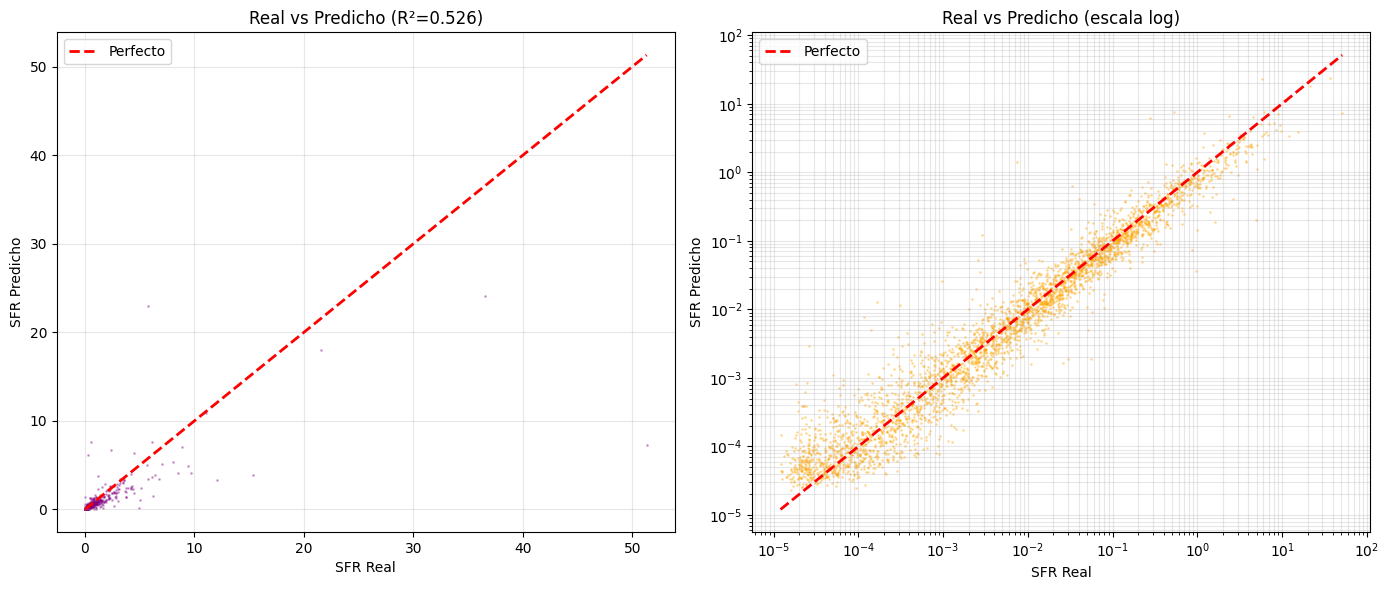

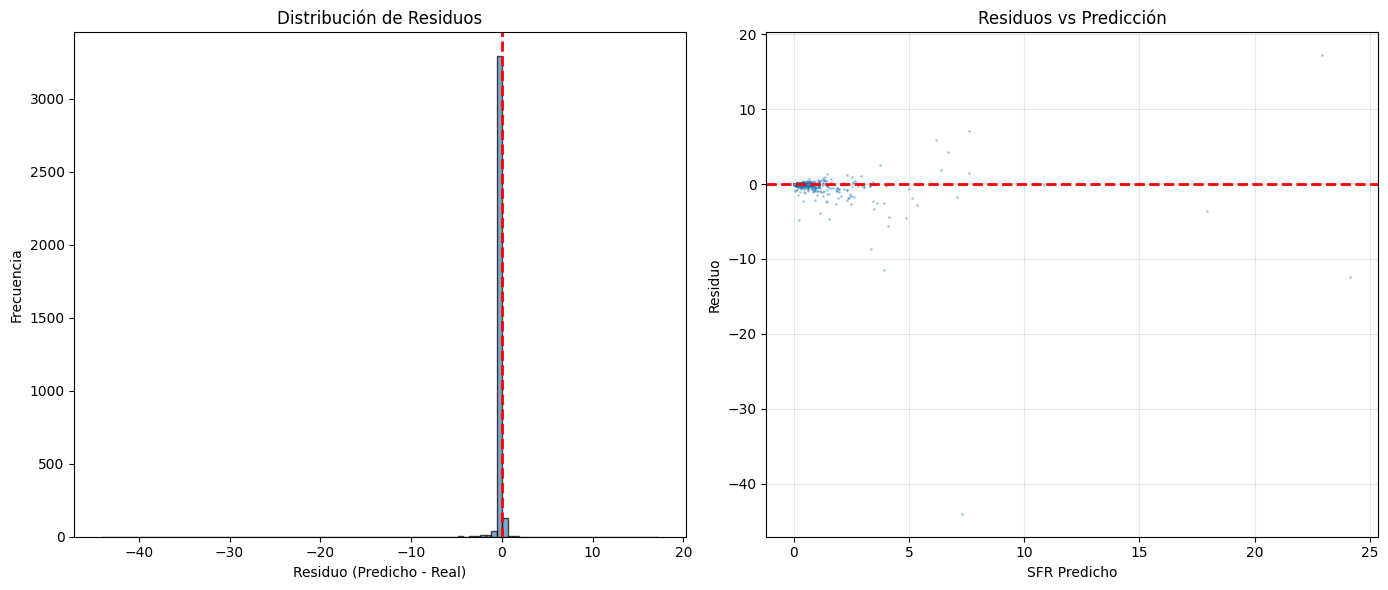


DESEMPEÑO POR RANGOS DE SFR
P0-P25: R²=-63.235, MAE=0.00016, n=878
P25-P50: R²=-9.311, MAE=0.00131, n=878
P50-P75: R²=-12.093, MAE=0.01202, n=877
P75-P90: R²=-12.876, MAE=0.06135, n=527
P90-P100: R²=0.440, MAE=0.80605, n=351

✅ ¡Regresión completada!

💾 Para guardar el modelo:
   import joblib
   joblib.dump(best_model, 'sfr_regressor.pkl')


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    make_scorer,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

df = pd.read_pickle("tng099_clean.pkl")

# ============================================================
# 1) ANÁLISIS EXPLORATORIO DE SFR (CRÍTICO)
# ============================================================
print("="*60)
print("ANÁLISIS EXPLORATORIO - Distribución de SFR")
print("="*60)

df_reg = df.copy()

print(f"\nDataset original: {len(df_reg):,} galaxias")
print(f"Features totales: {len(df_reg.columns)}")

# Estadísticas de SFR ANTES de cualquier filtro
print("\n--- Estadísticas SFR ---")
print(df_reg['SubhaloSFR'].describe())
print(f"SFR = 0: {(df_reg['SubhaloSFR']==0).sum():,} ({(df_reg['SubhaloSFR']==0).sum()/len(df_reg)*100:.1f}%)")
print(f"SFR > 0: {(df_reg['SubhaloSFR']>0).sum():,} ({(df_reg['SubhaloSFR']>0).sum()/len(df_reg)*100:.1f}%)")

# Visualizar distribución
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribución completa
axes[0].hist(df_reg['SubhaloSFR'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('SFR')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de SFR (escala lineal)')
axes[0].set_yscale('log')

# Solo SFR > 0
sfr_positive = df_reg[df_reg['SubhaloSFR'] > 0]['SubhaloSFR']
axes[1].hist(sfr_positive, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('SFR')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribución SFR > 0 (n={len(sfr_positive):,})')
axes[1].set_yscale('log')

# Log-scale (SFR > 0)
axes[2].hist(np.log10(sfr_positive + 1e-10), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[2].set_xlabel('log10(SFR)')
axes[2].set_ylabel('Frecuencia')
axes[2].set_title('Distribución log10(SFR)')

plt.tight_layout()
plt.show()

# ============================================================
# 2) ELIMINACIÓN DE COLUMNAS SFR (evitar data leakage)
# ============================================================
print("\n" + "="*60)
print("LIMPIEZA DE FEATURES - Eliminar leakage de SFR")
print("="*60)

cols_sfr = [col for col in df_reg.columns if "SFR" in col and col != "SubhaloSFR"]

if len(cols_sfr) > 0:
    print(f"\nEliminando {len(cols_sfr)} columnas relacionadas con SFR:")
    for c in cols_sfr:
        print(f"  - {c}")
    df_reg = df_reg.drop(columns=cols_sfr)
else:
    print("\n No hay columnas SFR adicionales que eliminar")

# Verificar si hay otras columnas sospechosas
suspicious_cols = [col for col in df_reg.columns if any(
    keyword in col.lower() 
    for keyword in ['star', 'stellar', 'formation']
) and col != "SubhaloSFR"]

if len(suspicious_cols) > 0:
    print(f"\n  Columnas potencialmente relacionadas con formación estelar:")
    for c in suspicious_cols:
        print(f"  - {c}")
    print("Considera si estas features causan leakage")

print(f"\nShape final: {df_reg.shape}")

# ============================================================
# 3) SAMPLING ESTRATÉGICO
# ============================================================
print("\n" + "="*60)
print("SAMPLING DEL DATASET")
print("="*60)

df_active = df_reg[df_reg['SubhaloSFR'] > 0].copy()
print(f"\n Usando solo galaxias con SFR > 0: {len(df_active):,}")

sample_size = min(500_000, len(df_active))
df_sample = df_active.sample(n=sample_size, random_state=42)

print(f"Dataset final para regresión: {len(df_sample):,}")
print(f"Features: {df_sample.shape[1] - 1}")

# ============================================================
# 4) PREPARACIÓN DE DATOS
# ============================================================
X = df_sample.drop("SubhaloSFR", axis=1)
y = df_sample["SubhaloSFR"]

skewness = y.skew()
print(f"\nSkewness de SFR: {skewness:.2f}")

if skewness > 2:
    print("→ SFR muy sesgado, considerar transformación log")
    use_log = True
    y_original = y.copy()
    y = np.log10(y + 1e-10)
    print("→ Aplicando log10(SFR) como target")
else:
    use_log = False
    print("→ Usando SFR sin transformar")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\nTrain: {len(X_train):,} muestras")
print(f"Test:  {len(X_test):,} muestras")
print(f"SFR train - min: {y_train.min():.4f}, max: {y_train.max():.4f}, mean: {y_train.mean():.4f}")
print(f"SFR test  - min: {y_test.min():.4f}, max: {y_test.max():.4f}, mean: {y_test.mean():.4f}")

# ============================================================
# 5) GRID SEARCH OPTIMIZADO
# ============================================================
print("\n" + "="*60)
print("CONFIGURACIÓN GRID SEARCH")
print("="*60)

# Grid más exhaustivo para regresión
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [15, 25, 40, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.5, 0.8],
    "min_samples_leaf": [1, 2, 5]
}

print(f"Combinaciones: {np.prod([len(v) for v in param_grid.values()])}")

# Métrica: Negative MSE (para minimizar)
neg_mse = make_scorer(mean_squared_error, greater_is_better=False)

rf = RandomForestRegressor(
    n_jobs=-1,
    random_state=42,
    oob_score=True  # Validación adicional
)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,  # Aumentado a 5 folds
    scoring=neg_mse,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

# ============================================================
# 6) ENTRENAMIENTO
# ============================================================
print("\n" + "="*60)
print("ENTRENAMIENTO")
print("="*60)

grid.fit(X_train, y_train)

# ============================================================
# 7) RESULTADOS
# ============================================================
print("\n" + "="*60)
print("MEJORES HIPERPARÁMETROS")
print("="*60)
for param, value in grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor score (neg-MSE): {grid.best_score_:.6f}")

# Top 5 combinaciones
results_df = pd.DataFrame(grid.cv_results_)
top_5 = results_df.nsmallest(5, 'rank_test_score')[
    ['rank_test_score', 'mean_test_score', 'std_test_score', 'params']
]
print("\n--- Top 5 configuraciones ---")
print(top_5.to_string())

# ============================================================
# 8) EVALUACIÓN EN TEST
# ============================================================
print("\n" + "="*60)
print("EVALUACIÓN EN TEST")
print("="*60)

best_model = grid.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Si usamos log, revertir transformación
if use_log:
    y_train_eval = 10 ** y_train
    y_test_eval = 10 ** y_test
    y_pred_train_eval = 10 ** y_pred_train
    y_pred_test_eval = 10 ** y_pred_test
else:
    y_train_eval = y_train
    y_test_eval = y_test
    y_pred_train_eval = y_pred_train
    y_pred_test_eval = y_pred_test

# Métricas completas
def evaluate_model(y_true, y_pred, set_name="Test"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE solo si no hay ceros
    if (y_true > 0).all():
        mape = mean_absolute_percentage_error(y_true, y_pred)
    else:
        mape = np.nan
    
    print(f"\n--- {set_name} Set ---")
    print(f"RMSE:  {rmse:.6f}")
    print(f"MAE:   {mae:.6f}")
    print(f"R²:    {r2:.6f}")
    if not np.isnan(mape):
        print(f"MAPE:  {mape*100:.2f}%")
    
    return rmse, mae, r2

rmse_train, mae_train, r2_train = evaluate_model(y_train_eval, y_pred_train_eval, "Train")
rmse_test, mae_test, r2_test = evaluate_model(y_test_eval, y_pred_test_eval, "Test")

print(f"\n>>> OOB Score: {best_model.oob_score_:.6f} <<<")

# Verificar overfitting
print(f"\n--- Diagnóstico de Overfitting ---")
print(f"R² Train: {r2_train:.4f}")
print(f"R² Test:  {r2_test:.4f}")
print(f"Diferencia: {abs(r2_train - r2_test):.4f}")

if r2_train - r2_test > 0.1:
    print("  Posible overfitting (diferencia > 0.1)")
elif r2_train - r2_test > 0.05:
    print(" Leve overfitting (diferencia 0.05-0.1)")
else:
    print(" Sin overfitting significativo")

# ============================================================
# 9) VISUALIZACIONES
# ============================================================

# 9.1) Feature Importance
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_n = min(20, len(importances))
axes[0].barh(range(top_n), importances.values[:top_n])
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(importances.index[:top_n])
axes[0].invert_yaxis()
axes[0].set_xlabel('Importancia')
axes[0].set_title(f'Top {top_n} Features Más Importantes')

cumsum = np.cumsum(importances.values)
axes[1].plot(range(1, len(cumsum)+1), cumsum, linewidth=2, color='teal')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95%')
axes[1].set_xlabel('Número de Features')
axes[1].set_ylabel('Importancia Acumulada')
axes[1].set_title('Importancia Acumulada')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n--- Top 15 Features ---")
print(importances.head(15))

n_features_95 = np.argmax(cumsum >= 0.95) + 1
print(f"\nFeatures para 95%: {n_features_95}/{len(importances)}")

# 9.2) Real vs Predicho
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test_eval, y_pred_test_eval, s=1, alpha=0.3, c='purple')
axes[0].plot([y_test_eval.min(), y_test_eval.max()], 
             [y_test_eval.min(), y_test_eval.max()], 
             "r--", lw=2, label='Perfecto')
axes[0].set_xlabel('SFR Real')
axes[0].set_ylabel('SFR Predicho')
axes[0].set_title(f'Real vs Predicho (R²={r2_test:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Log-log scale para ver mejor
axes[1].scatter(y_test_eval, y_pred_test_eval, s=1, alpha=0.3, c='orange')
axes[1].plot([y_test_eval.min(), y_test_eval.max()], 
             [y_test_eval.min(), y_test_eval.max()], 
             "r--", lw=2, label='Perfecto')
axes[1].set_xlabel('SFR Real')
axes[1].set_ylabel('SFR Predicho')
axes[1].set_title('Real vs Predicho (escala log)')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# 9.3) Residuos
residuals = y_pred_test_eval - y_test_eval

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(residuals, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Residuo (Predicho - Real)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Residuos')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)

axes[1].scatter(y_pred_test_eval, residuals, s=1, alpha=0.3)
axes[1].axhline(0, color="red", linestyle="--", linewidth=2)
axes[1].set_xlabel('SFR Predicho')
axes[1].set_ylabel('Residuo')
axes[1].set_title('Residuos vs Predicción')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9.4) Análisis por rangos de SFR
print("\n" + "="*60)
print("DESEMPEÑO POR RANGOS DE SFR")
print("="*60)

percentiles = [0, 25, 50, 75, 90, 100]
bins = np.percentile(y_test_eval, percentiles)
bin_labels = [f"P{percentiles[i]}-P{percentiles[i+1]}" for i in range(len(bins)-1)]

y_test_binned = pd.cut(y_test_eval, bins=bins, labels=bin_labels, include_lowest=True)

for label in bin_labels:
    mask = y_test_binned == label
    if mask.sum() > 0:
        r2_bin = r2_score(y_test_eval[mask], y_pred_test_eval[mask])
        mae_bin = mean_absolute_error(y_test_eval[mask], y_pred_test_eval[mask])
        print(f"{label}: R²={r2_bin:.3f}, MAE={mae_bin:.5f}, n={mask.sum()}")

print("\n ¡Regresión completada!")
print("\n Para guardar el modelo:")
print("   import joblib")
print("   joblib.dump(best_model, 'sfr_regressor.pkl')")

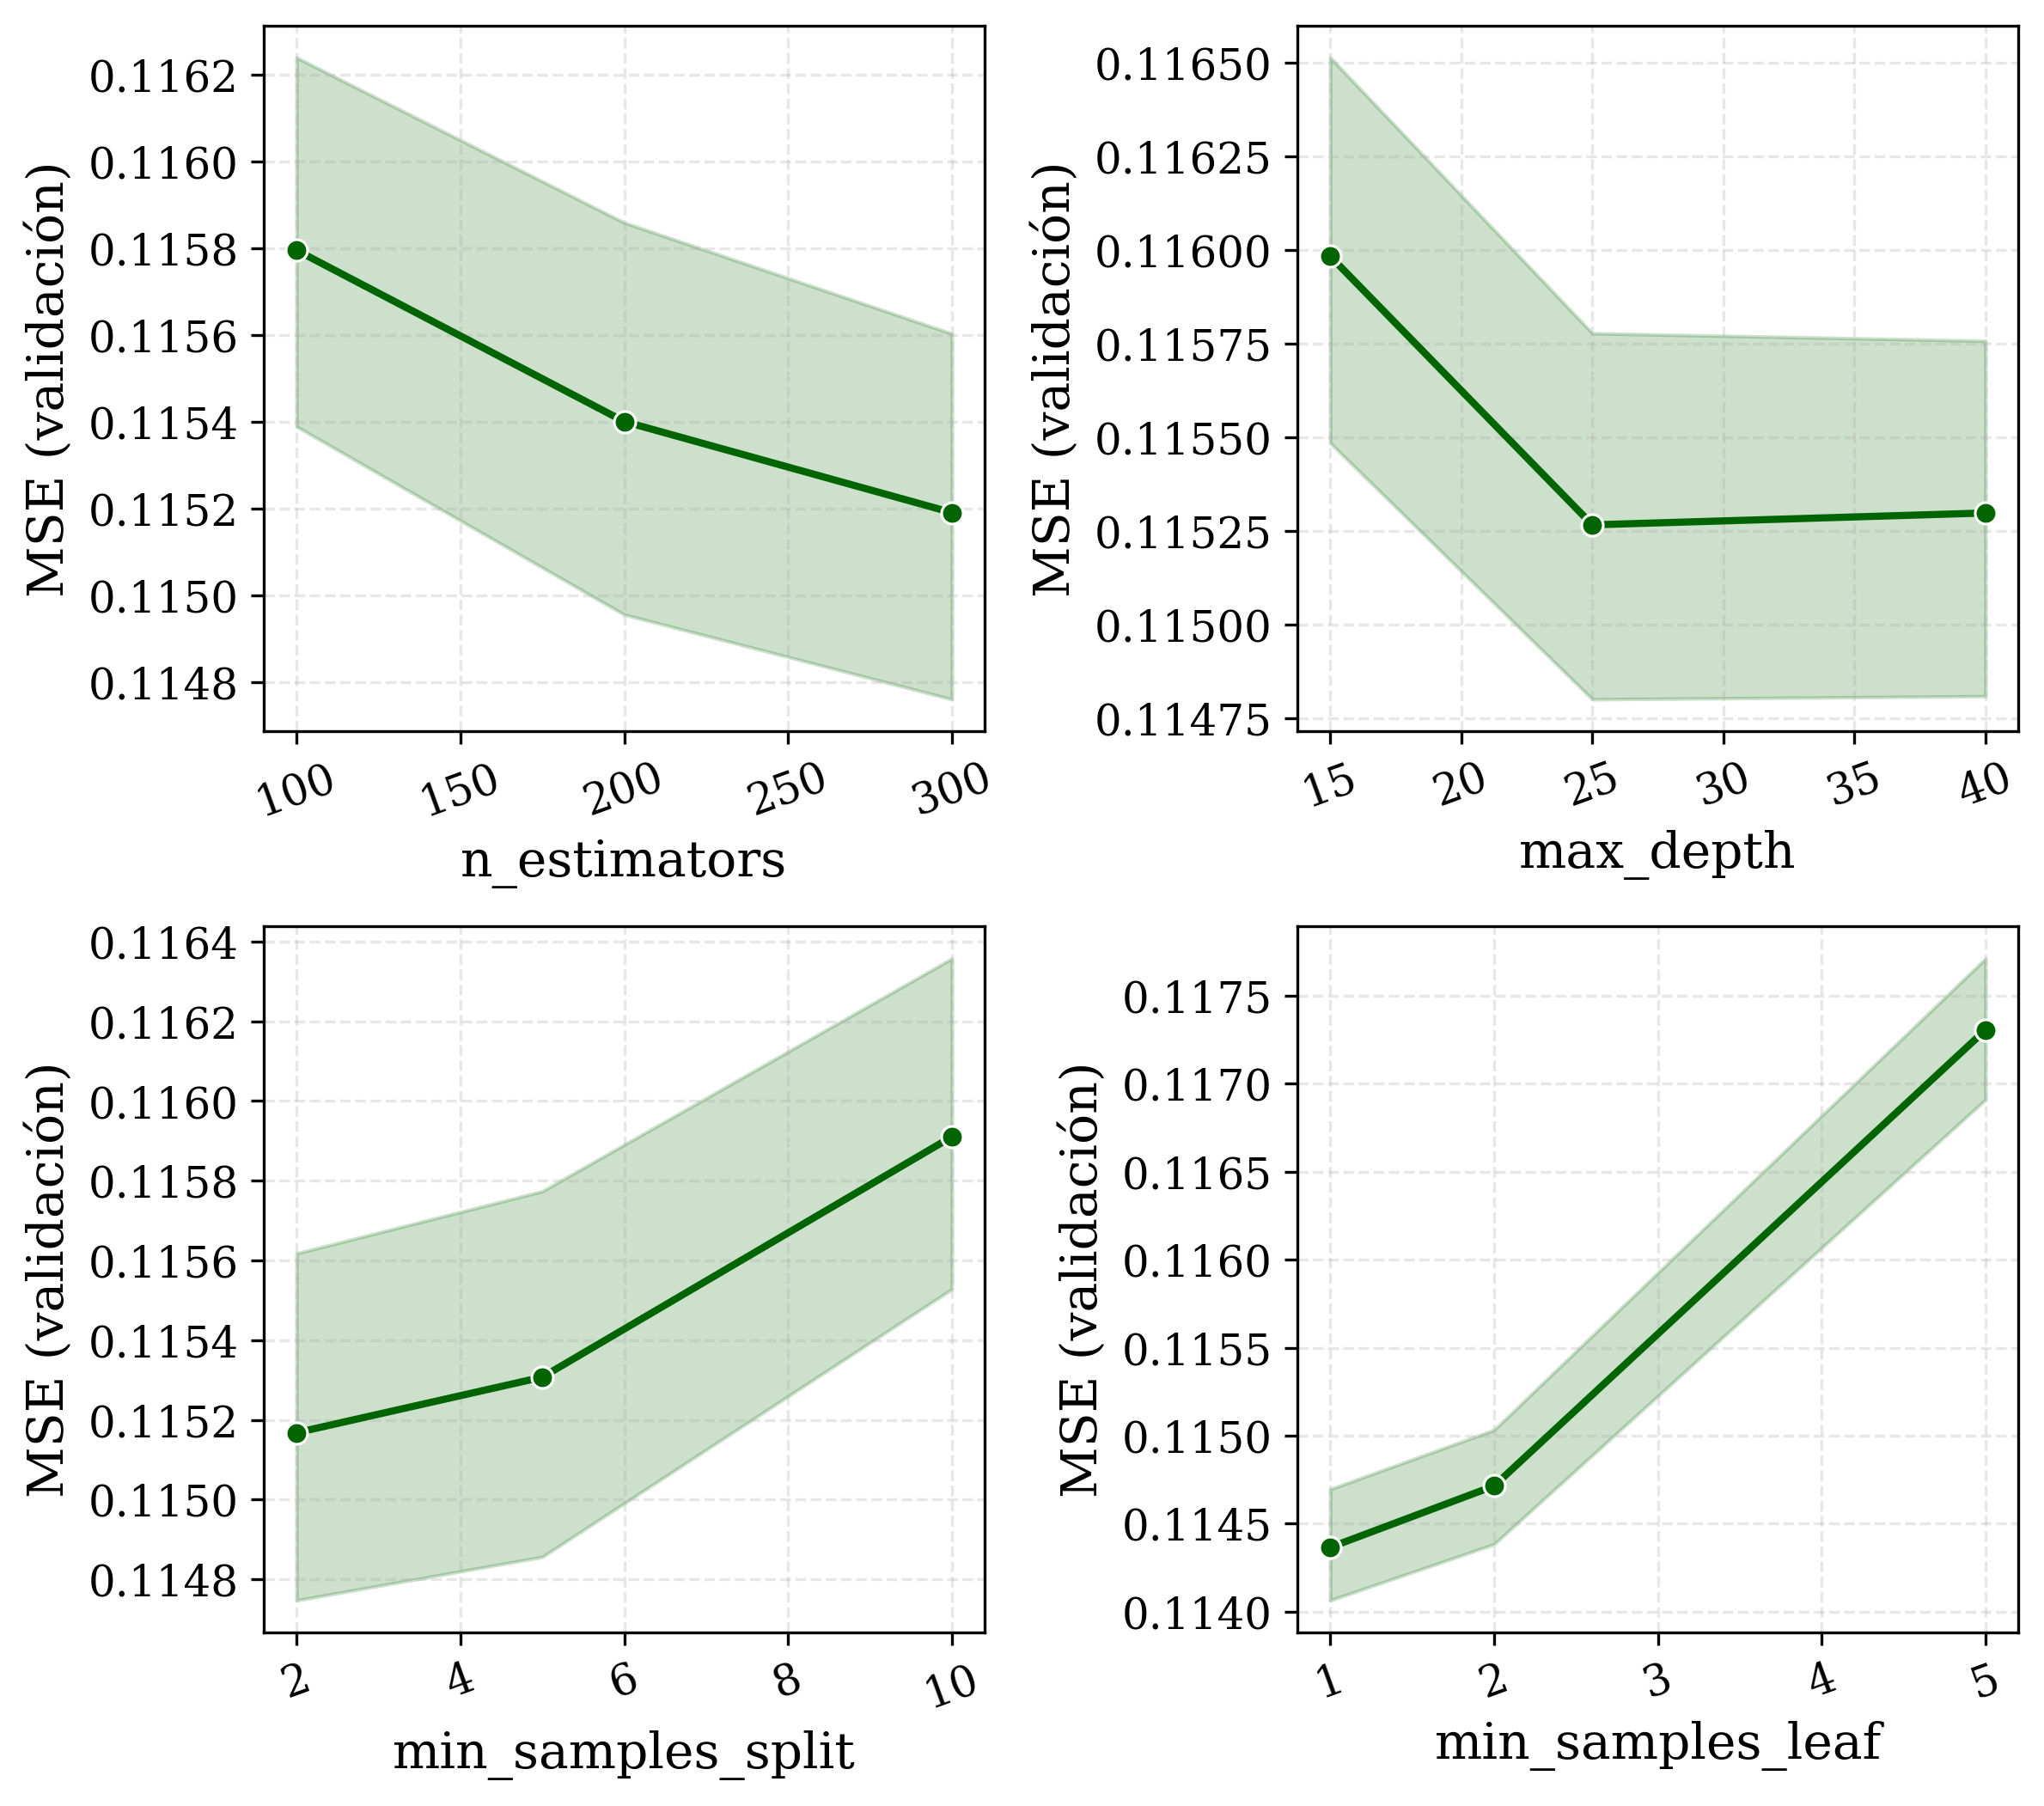

In [8]:
res_r = pd.DataFrame(grid.cv_results_)
res_r["mse"] = -res_r["mean_test_score"]  # invertimos signo

params = [
    "param_n_estimators",
    "param_max_depth",
    "param_min_samples_split",
    "param_min_samples_leaf"
]

titles = [
    "n_estimators",
    "max_depth",
    "min_samples_split",
    "min_samples_leaf"
]

plt.figure(figsize=(8, 10))  # Figura de una columna, estilo 'tall'

for i, (param, title) in enumerate(zip(params, titles), 1):
    plt.subplot(3, 2, i)

    vals = res_r[param].apply(lambda x: np.nan if x is None else x)

    sns.lineplot(
        x=vals,
        y=res_r["mse"],
        marker="o",
        lw=2,
        ms=6,
        color="darkgreen"
    )

    plt.xlabel(title, fontsize=14)
    plt.ylabel("MSE (validación)", fontsize=14)
    plt.xticks(fontsize=12, rotation=20)
    plt.yticks(fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("img/sfr_hyperparam_grid_all.png", dpi=300)
plt.show()


Cargando datos...
Sesgo alto (26.41). Aplicando log10(SFR).
Entrenando modelo...
Calculando métricas en ambos espacios...
R2 Logarítmico: 0.9461
R2 Lineal: 0.5225
Generando figuras en español...


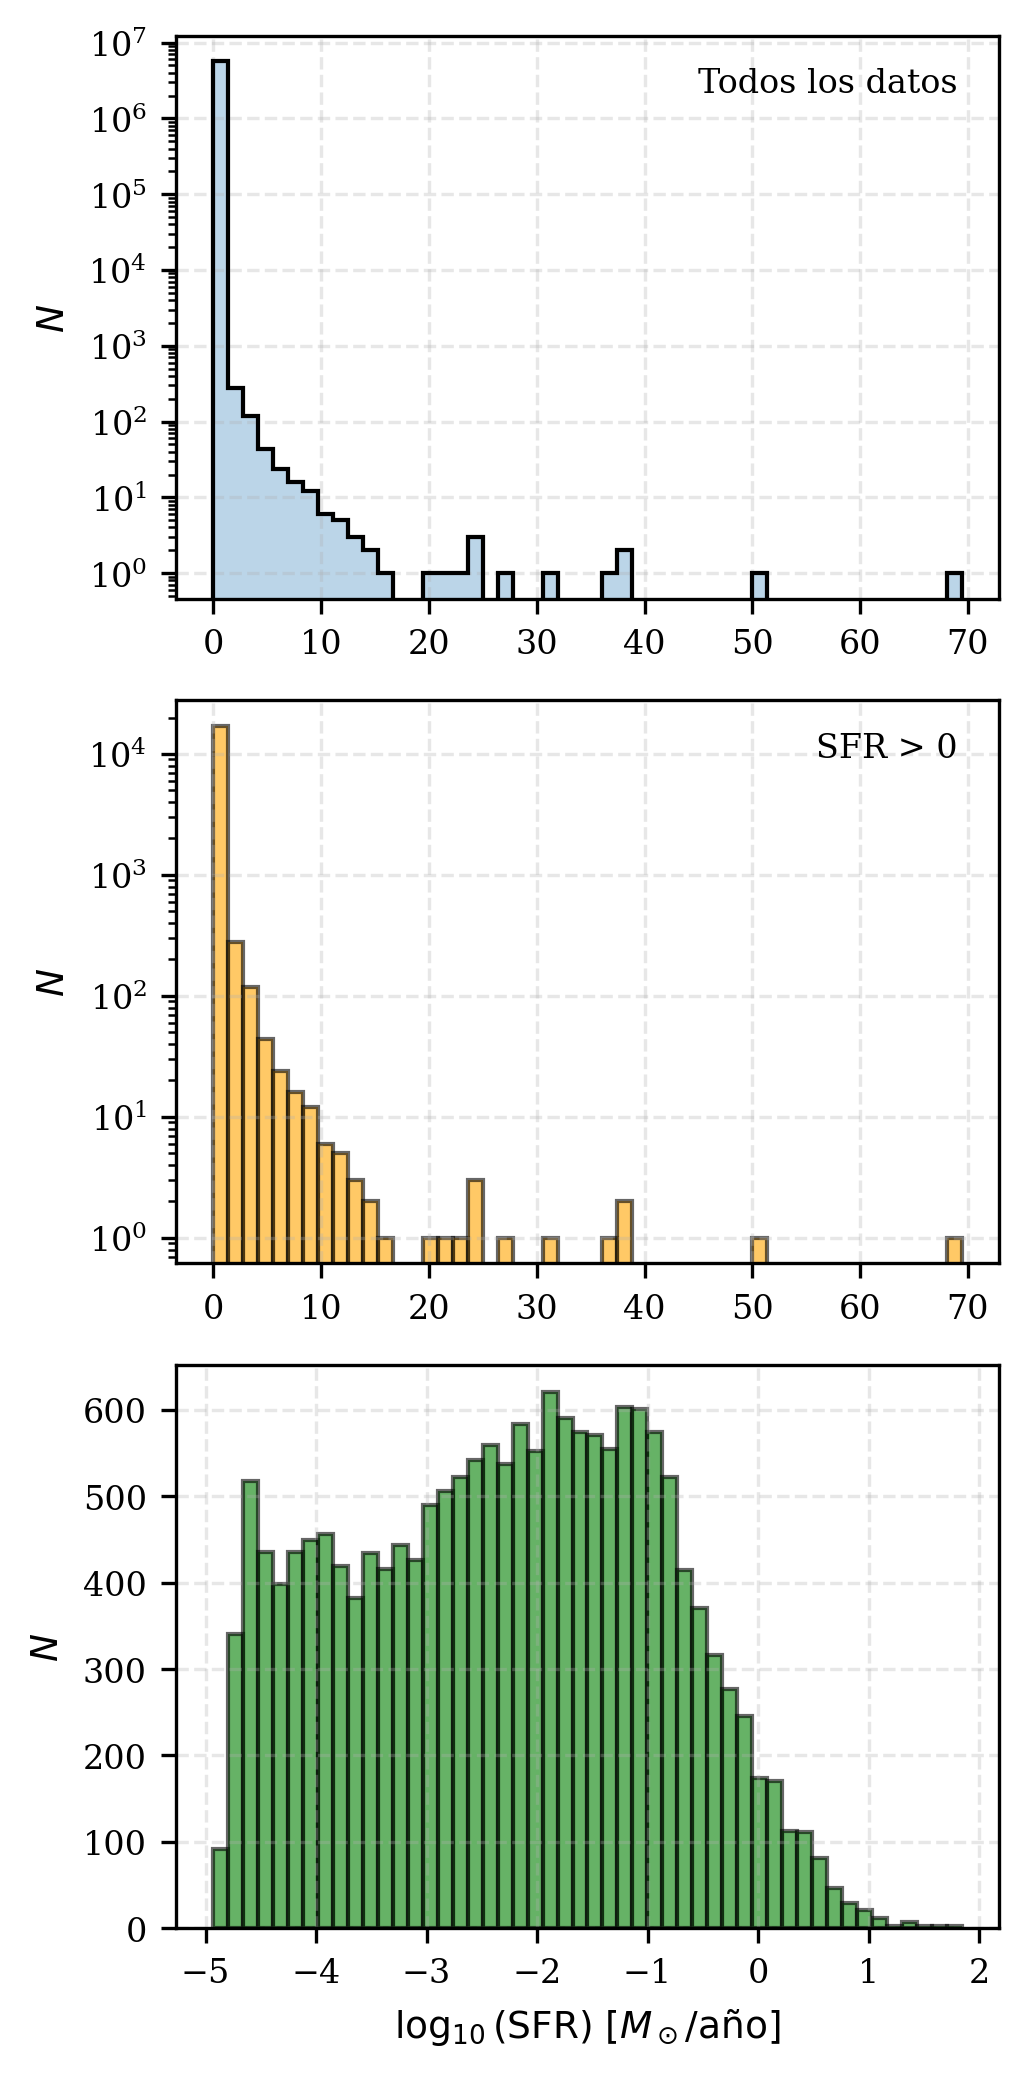

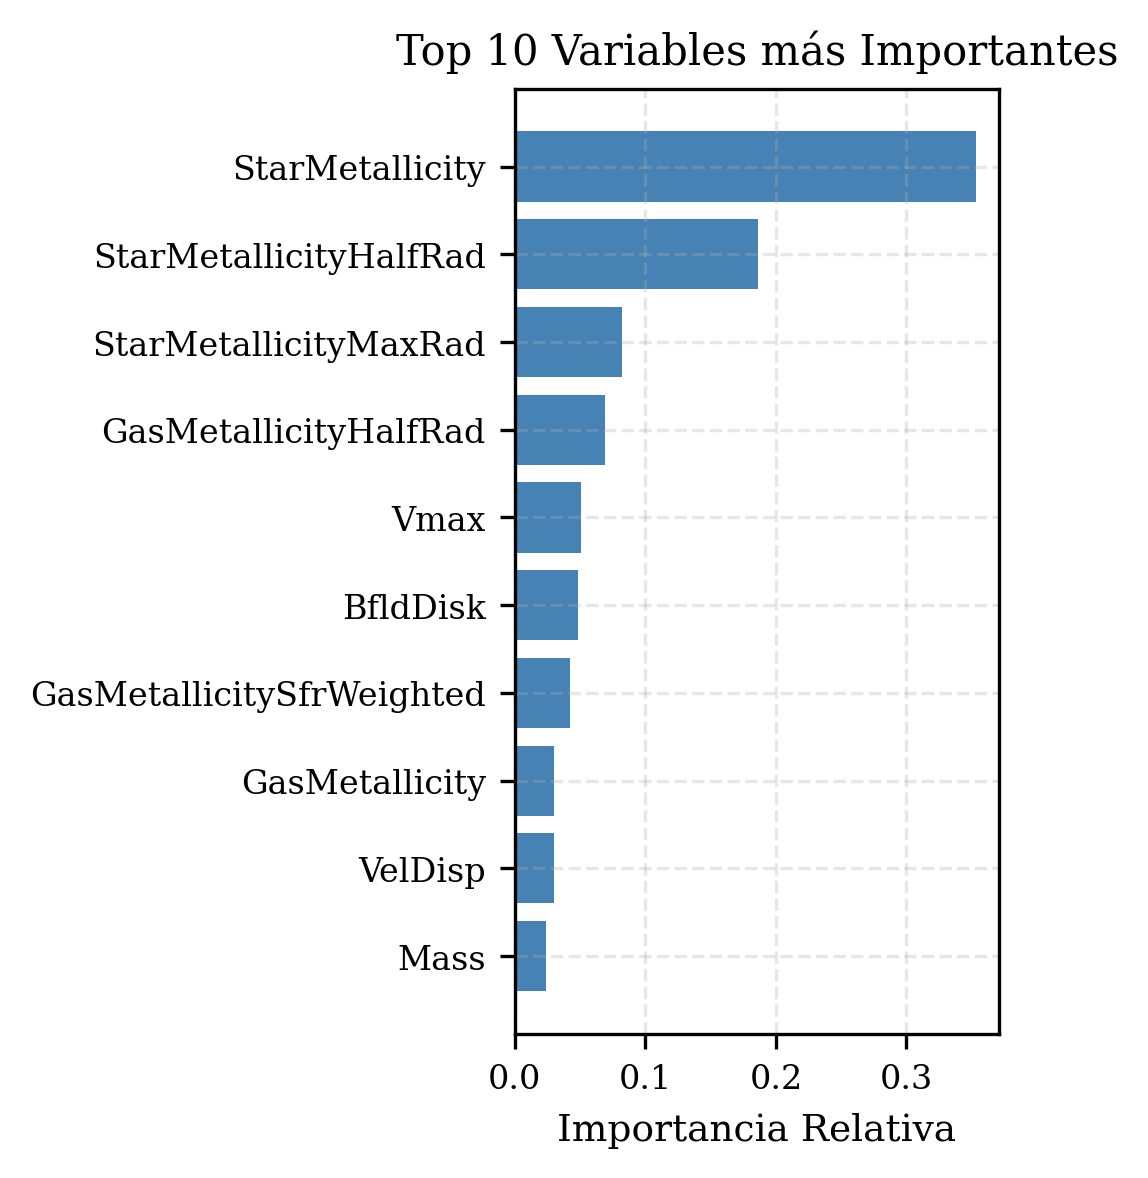

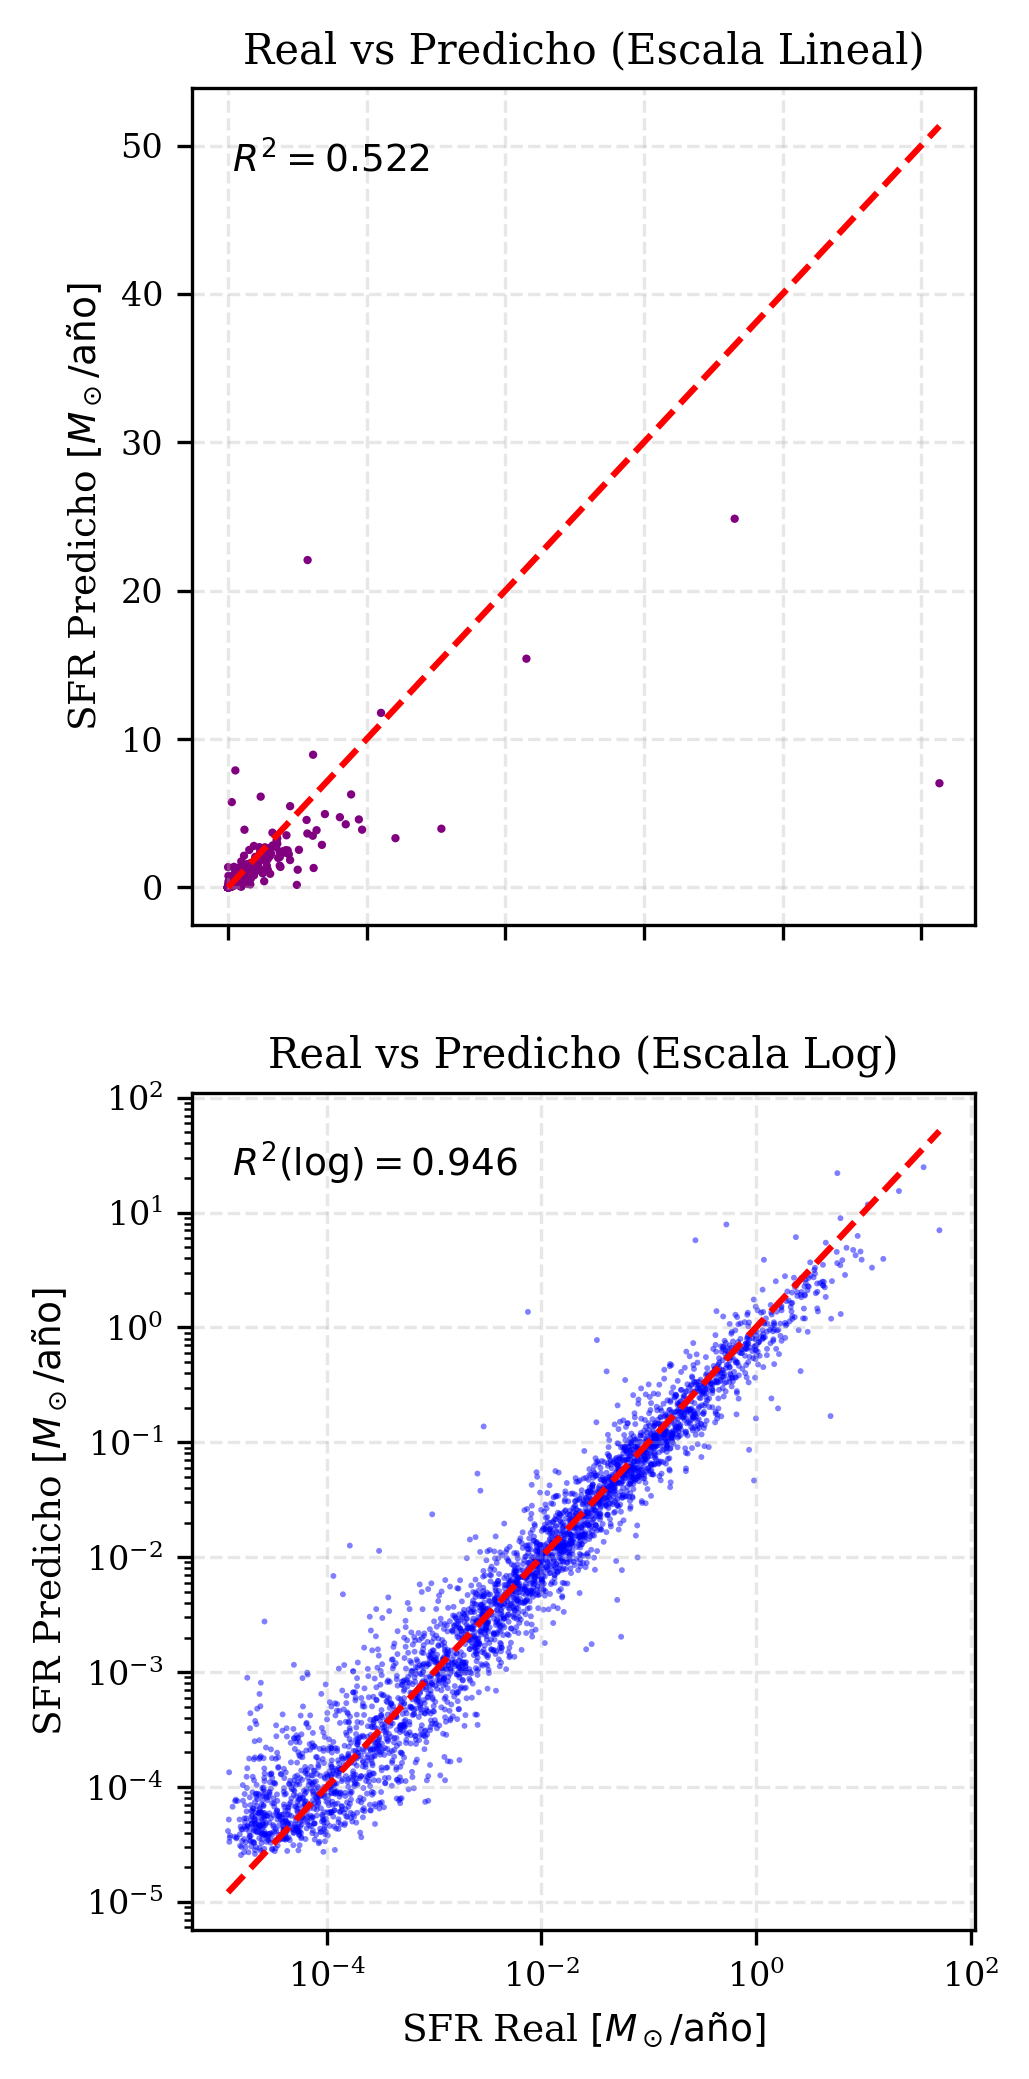

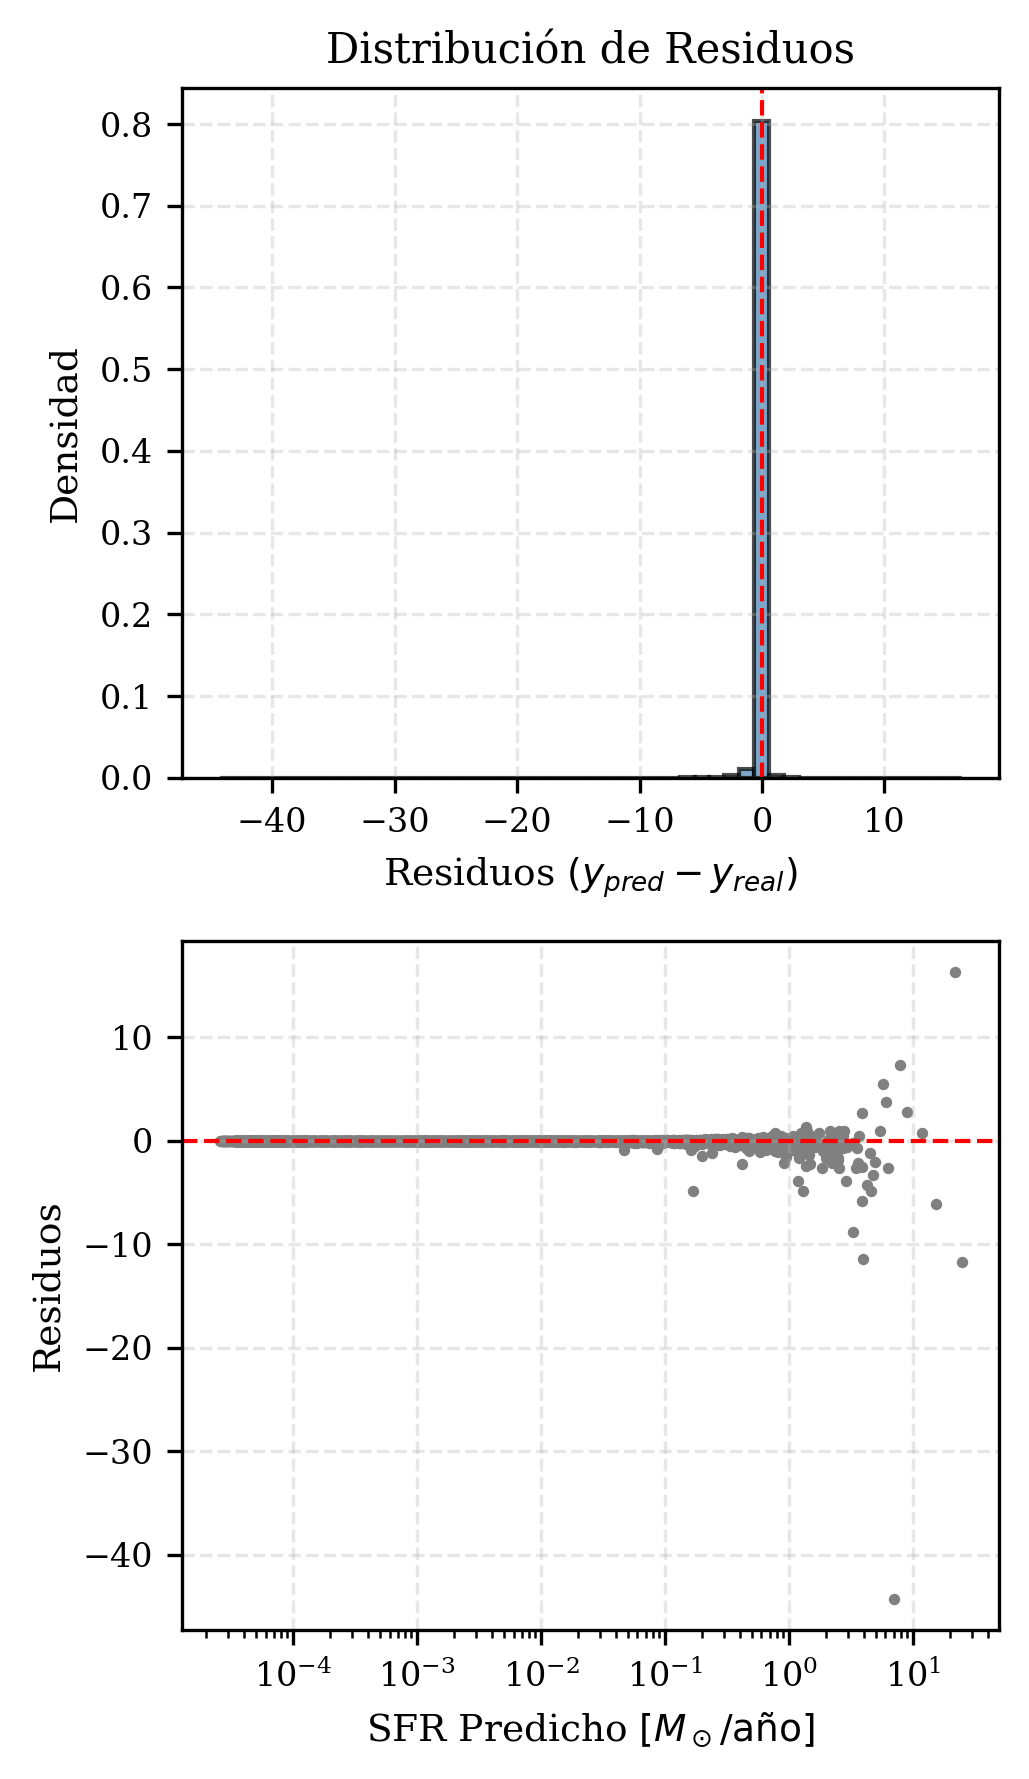


✅ Figuras generadas. Revisa Fig 3 para ver ambos coeficientes R2.


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')

SINGLE_COL_WIDTH = 3.5 

plt.rcParams.update({
    'figure.figsize': (SINGLE_COL_WIDTH, SINGLE_COL_WIDTH * 0.8),
    'figure.dpi': 300,
    'font.size': 9,
    'font.family': 'serif',       
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 7,
    'lines.linewidth': 1.5,
    'scatter.edgecolors': 'none',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--'
})


print("Cargando datos...")
df = pd.read_pickle("tng099_clean.pkl")
df_reg = df.copy()

# Limpieza de columnas SFR (Leakage)
cols_sfr = [col for col in df_reg.columns if "SFR" in col and col != "SubhaloSFR"]
if len(cols_sfr) > 0:
    df_reg = df_reg.drop(columns=cols_sfr)

# Sampling (Solo SFR > 0)
df_active = df_reg[df_reg['SubhaloSFR'] > 0].copy()
sample_size = min(500_000, len(df_active))
df_sample = df_active.sample(n=sample_size, random_state=42)

X = df_sample.drop("SubhaloSFR", axis=1)
y = df_sample["SubhaloSFR"]

# Transformación Logarítmica si es necesaria
skewness = y.skew()
use_log = False
if skewness > 2:
    print(f"Sesgo alto ({skewness:.2f}). Aplicando log10(SFR).")
    use_log = True
    y = np.log10(y + 1e-10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ============================================================
# ENTRENAMIENTO (Mejores Hiperparámetros)
# ============================================================
rf_final = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    max_features=0.5,
    min_samples_leaf=1,
    min_samples_split=2,
    n_jobs=-1,
    random_state=42
)

print("Entrenando modelo...")
rf_final.fit(X_train, y_train)
best_model = rf_final

# ============================================================
# CÁLCULO DE MÉTRICAS (CORRECCIÓN R2)
# ============================================================
print("Calculando métricas en ambos espacios...")

y_pred_raw = best_model.predict(X_test)

if use_log:
    # 1. R2 en espacio LOG (Espacio de entrenamiento)
    r2_log = r2_score(y_test, y_pred_raw)
    
    # 2. R2 en espacio LINEAL (Espacio físico real)
    y_test_linear = 10 ** y_test
    y_pred_linear = 10 ** y_pred_raw
    r2_linear = r2_score(y_test_linear, y_pred_linear)
    
    print(f"R2 Logarítmico: {r2_log:.4f}")
    print(f"R2 Lineal: {r2_linear:.4f}")
    
    y_plot_linear_real = y_test_linear
    y_plot_linear_pred = y_pred_linear
    
else:
    r2_linear = r2_score(y_test, y_pred_raw)
    r2_log = r2_linear # Son el mismo espacio
    
    y_plot_linear_real = y_test
    y_plot_linear_pred = y_pred_raw


print("Generando figuras en español...")

# ============================================================
# FIGURA 1: Distribuciones (3 paneles verticales)
# ============================================================
fig, axes = plt.subplots(3, 1, figsize=(SINGLE_COL_WIDTH, 7), sharex=False)

# Panel 1: Todos los datos
axes[0].hist(df_reg['SubhaloSFR'], bins=50, edgecolor='black', histtype='stepfilled', alpha=0.3)
axes[0].hist(df_reg['SubhaloSFR'], bins=50, edgecolor='black', histtype='step', color='k')
axes[0].set_ylabel(r'$N$')
axes[0].set_yscale('log')
axes[0].text(0.95, 0.9, 'Todos los datos', transform=axes[0].transAxes, ha='right', fontsize=8)

# Panel 2: SFR > 0
sfr_positive = df_reg[df_reg['SubhaloSFR'] > 0]['SubhaloSFR']
axes[1].hist(sfr_positive, bins=50, color='orange', edgecolor='black', alpha=0.6)
axes[1].set_ylabel(r'$N$')
axes[1].set_yscale('log')
axes[1].text(0.95, 0.9, 'SFR > 0', transform=axes[1].transAxes, ha='right', fontsize=8)

# Panel 3: Escala Log
axes[2].hist(np.log10(sfr_positive + 1e-10), bins=50, color='green', edgecolor='black', alpha=0.6)
axes[2].set_xlabel(r'$\log_{10}(\mathrm{SFR})$ $[M_\odot/\mathrm{año}]$')
axes[2].set_ylabel(r'$N$')

plt.tight_layout()
plt.savefig('fig1_distribuciones.pdf', bbox_inches='tight')
plt.show()

# ============================================================
# FIGURA 2: Feature Importance (SOLO TOP 10)
# ============================================================
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
clean_index = [name.replace('Subhalo', '').replace('_', ' ') for name in importances.index]
importances.index = clean_index

top_n = 10
fig, ax = plt.subplots(figsize=(SINGLE_COL_WIDTH, 4)) 

ax.barh(range(top_n), importances.values[:top_n], color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(importances.index[:top_n], fontsize=8) 
ax.invert_yaxis() 
ax.set_xlabel('Importancia Relativa')
ax.set_title('Top 10 Variables más Importantes')

plt.tight_layout()
plt.savefig('fig2_top10_features.pdf', bbox_inches='tight')
plt.show()

# ============================================================
# FIGURA 2b: Acumulada
# ============================================================
cumsum = np.cumsum(importances.values)
fig, ax = plt.subplots(figsize=(SINGLE_COL_WIDTH, 3))
ax.plot(range(1, len(cumsum)+1), cumsum, linewidth=1.5, color='teal')
ax.axhline(y=0.95, color='r', linestyle='--', linewidth=1, label='95%')
ax.set_xlabel('Número de Variables')
ax.set_ylabel('Importancia Acumulada')
ax.legend(loc='lower right')
ax.set_title('Importancia Acumulada')
plt.tight_layout()
plt.savefig('fig2b_acumulada.pdf', bbox_inches='tight')
plt.close()

# ============================================================
# FIGURA 3: Real vs Predicho (CORREGIDA CON DOBLE R2)
# ============================================================
fig, axes = plt.subplots(2, 1, figsize=(SINGLE_COL_WIDTH, 7))

# Panel 1: Escala Lineal (Usa R2 Lineal)
axes[0].scatter(y_plot_linear_real, y_plot_linear_pred, s=4, alpha=1, c='purple', rasterized=True)
axes[0].plot([y_plot_linear_real.min(), y_plot_linear_real.max()], 
             [y_plot_linear_real.min(), y_plot_linear_real.max()], 
             "r--", lw=1.5)
axes[0].set_ylabel(r'SFR Predicho $[M_\odot/\mathrm{año}]$')
axes[0].set_xticklabels([]) 
# AQUI MOSTRAMOS EL R2 LINEAL
axes[0].text(0.05, 0.9, f'$R^2 = {r2_linear:.3f}$', transform=axes[0].transAxes)
axes[0].set_title('Real vs Predicho (Escala Lineal)')

# Panel 2: Escala Logarítmica (Usa R2 Logarítmico)
axes[1].scatter(y_plot_linear_real, y_plot_linear_pred, s=2, alpha=0.5, c='b', rasterized=True)
axes[1].plot([y_plot_linear_real.min(), y_plot_linear_real.max()], 
             [y_plot_linear_real.min(), y_plot_linear_real.max()], 
             "r--", lw=1.5)
axes[1].set_xlabel(r'SFR Real $[M_\odot/\mathrm{año}]$')
axes[1].set_ylabel(r'SFR Predicho $[M_\odot/\mathrm{año}]$')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
# AQUI MOSTRAMOS EL R2 LOGARÍTMICO
axes[1].text(0.05, 0.9, f'$R^2 (\log) = {r2_log:.3f}$', transform=axes[1].transAxes)
axes[1].set_title('Real vs Predicho (Escala Log)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.2) # Un poco más de espacio para los títulos
plt.savefig('fig3_pred_vs_real.png', bbox_inches='tight')
plt.show()

# ============================================================
# FIGURA 4: Residuos (2 paneles verticales)
# ============================================================
residuals = y_plot_linear_pred - y_plot_linear_real
fig, axes = plt.subplots(2, 1, figsize=(SINGLE_COL_WIDTH, 6))

# Histograma
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue', density=True)
axes[0].set_xlabel(r'Residuos $(y_{pred} - y_{real})$')
axes[0].set_ylabel('Densidad')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Distribución de Residuos')

# Scatter
axes[1].scatter(y_plot_linear_pred, residuals, s=3, alpha=1, color='gray', rasterized=True)
axes[1].axhline(0, color="red", linestyle="--", linewidth=1)
axes[1].set_xlabel(r'SFR Predicho $[M_\odot/\mathrm{año}]$')
axes[1].set_ylabel('Residuos')
if use_log:
    axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('fig4_residuos.png', bbox_inches='tight')
plt.show()

print("\n Figuras generadas. Revisa Fig 3 para ver ambos coeficientes R2.")

ANÁLISIS EXPLORATORIO - Distribución de SFR


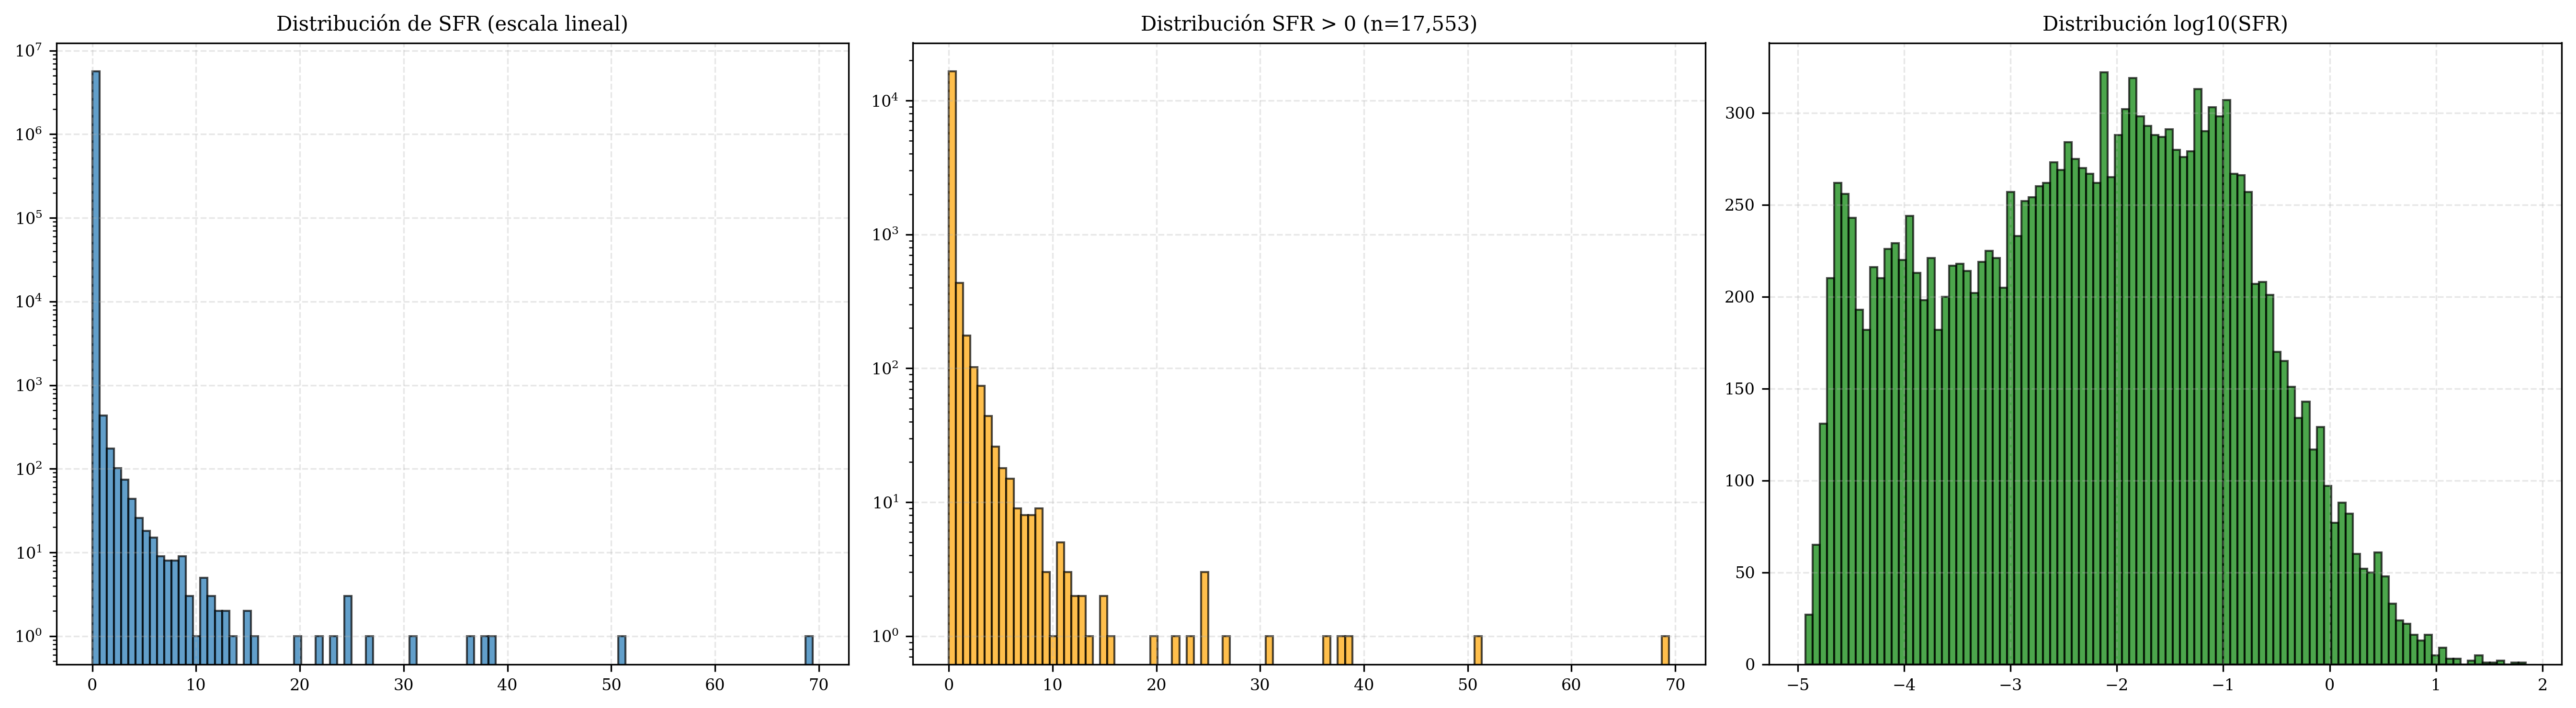


LIMPIEZA DE FEATURES - Eliminar leakage (SFR y Radios)
⚠️ Eliminando 12 columnas para evitar data leakage:
  - SubhaloStarMetallicityHalfRad
  - SubhaloSFRinHalfRad
  - SubhaloHalfmassRad
  - SubhaloMassInHalfRad
  - SubhaloMassInRad
  - SubhaloMassInMaxRad
  - SubhaloSFRinMaxRad
  - SubhaloStarMetallicityMaxRad
  - SubhaloGasMetallicityHalfRad
  - SubhaloVmaxRad
  ... y 2 más.

Features restantes: 13

Skewness alto (26.41). Aplicando log10(SFR).
Train: 14,042 | Test: 3,511

ENTRENAMIENTO DEL MODELO
✓ Modelo entrenado exitosamente.

EVALUACIÓN EN TEST
R² Train (Log space): 0.9915
R² Test  (Log space): 0.9412
R² Test  (Linear space): 0.4899

>>> OOB Score: 0.937305 <<<
Diferencia (Train-Test en Log): 0.0503


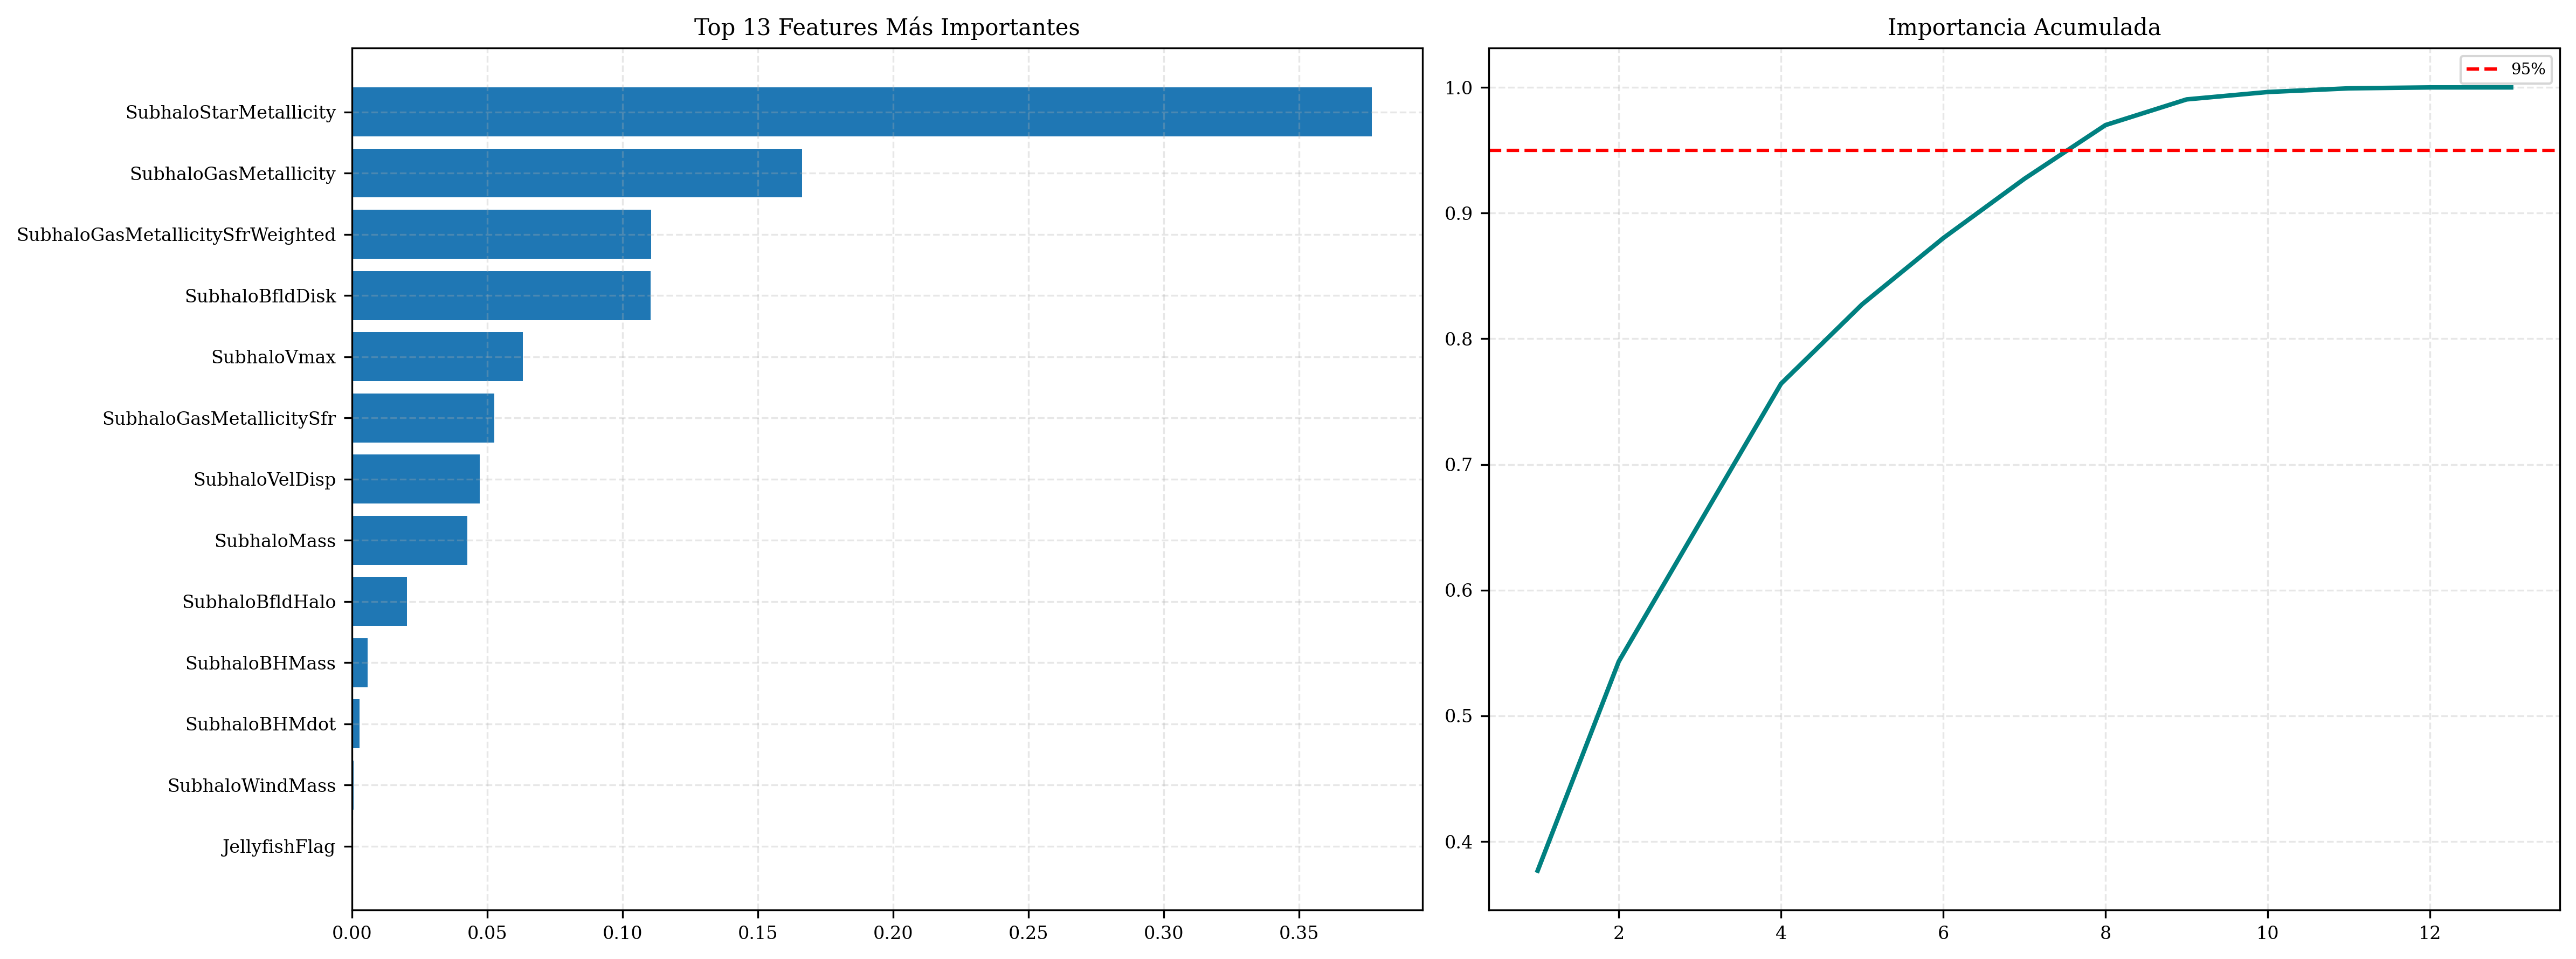

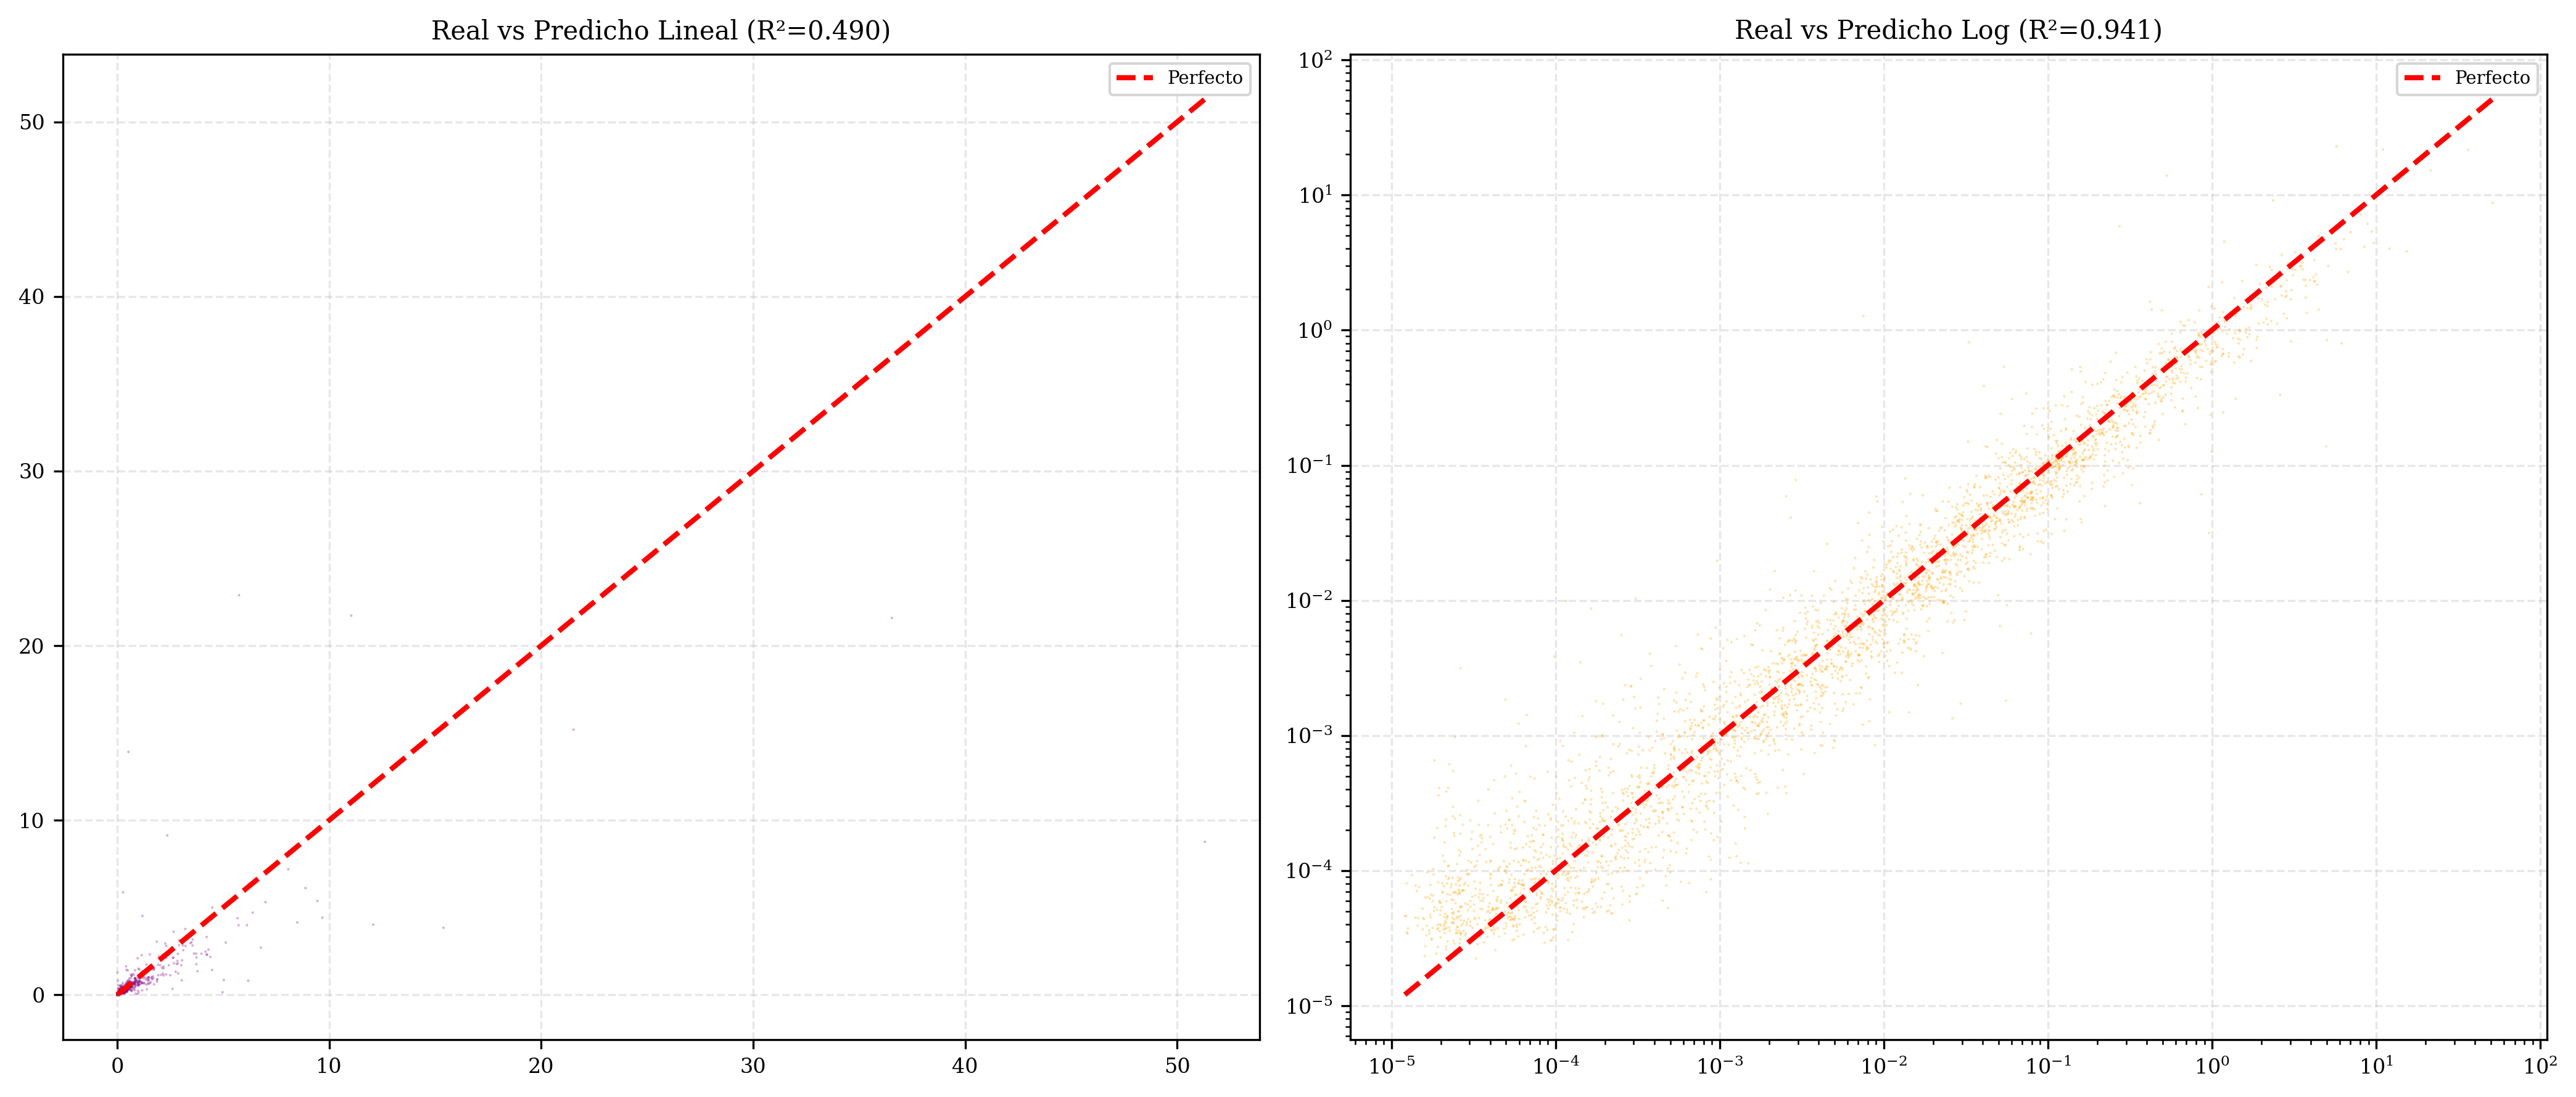

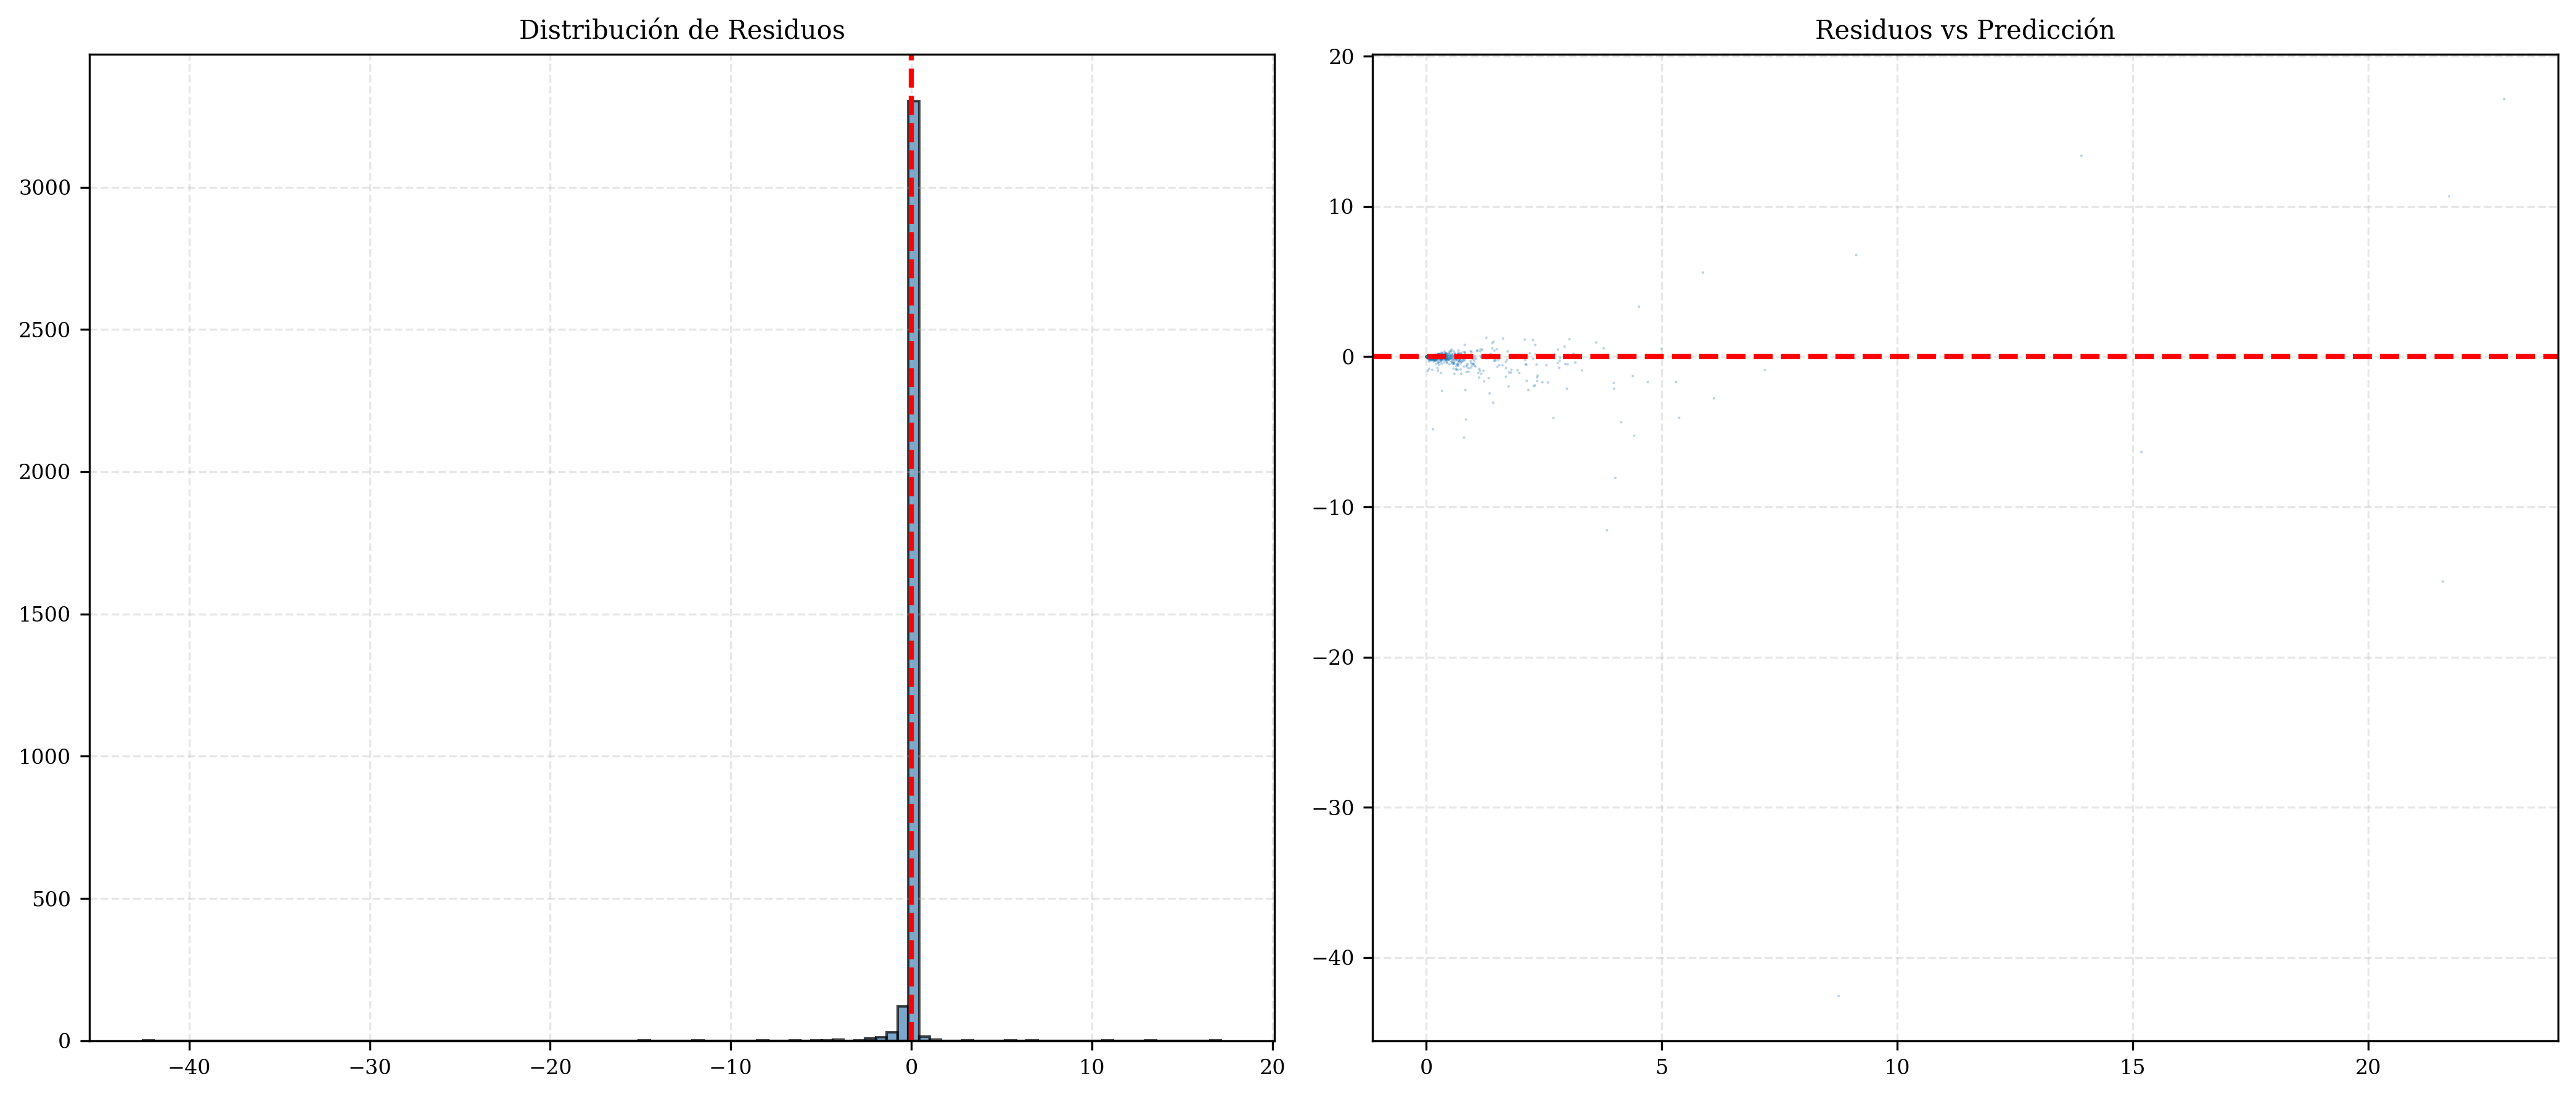


✅ Regresión completada (sin leakage de radios).


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
df = pd.read_pickle("tng099_clean.pkl")

# ============================================================
# 1) ANÁLISIS EXPLORATORIO DE SFR
# ============================================================
print("="*60)
print("ANÁLISIS EXPLORATORIO - Distribución de SFR")
print("="*60)

df_reg = df.copy()

# Visualizar distribución
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].hist(df_reg['SubhaloSFR'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de SFR (escala lineal)')
axes[0].set_yscale('log')

sfr_positive = df_reg[df_reg['SubhaloSFR'] > 0]['SubhaloSFR']
axes[1].hist(sfr_positive, bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title(f'Distribución SFR > 0 (n={len(sfr_positive):,})')
axes[1].set_yscale('log')

axes[2].hist(np.log10(sfr_positive + 1e-10), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('Distribución log10(SFR)')
plt.tight_layout()
plt.show()

# ============================================================
# 2) ELIMINACIÓN DE COLUMNAS CON LEAKAGE (SFR + RAD)
# ============================================================
print("\n" + "="*60)
print("LIMPIEZA DE FEATURES - Eliminar leakage (SFR y Radios)")
print("="*60)

# 1. Identificar columnas de SFR extra (excepto el target)
cols_sfr = [col for col in df_reg.columns if "SFR" in col and col != "SubhaloSFR"]

# 2. Identificar columnas que contengan "rad" o "Rad"
cols_rad = [col for col in df_reg.columns if "rad" in col.lower()]

# Unir ambas listas y eliminar duplicados
cols_to_drop = list(set(cols_sfr + cols_rad))

if len(cols_to_drop) > 0:
    print(f"⚠️ Eliminando {len(cols_to_drop)} columnas para evitar data leakage:")
    # Imprimir las primeras 10 para verificar
    for c in cols_to_drop[:10]:
        print(f"  - {c}")
    if len(cols_to_drop) > 10:
        print(f"  ... y {len(cols_to_drop)-10} más.")
    
    df_reg = df_reg.drop(columns=cols_to_drop)
else:
    print("✓ No se encontraron columnas sospechosas adicionales.")

print(f"\nFeatures restantes: {df_reg.shape[1] - 1}") # -1 por el target

# ============================================================
# 3) SAMPLING Y PREPARACIÓN
# ============================================================
# Usando solo galaxias con SFR > 0
df_active = df_reg[df_reg['SubhaloSFR'] > 0].copy()
sample_size = min(500_000, len(df_active))
df_sample = df_active.sample(n=sample_size, random_state=42)

X = df_sample.drop("SubhaloSFR", axis=1)
y = df_sample["SubhaloSFR"]

# Transformación Logarítmica
skewness = y.skew()
use_log = False
if skewness > 2:
    print(f"\nSkewness alto ({skewness:.2f}). Aplicando log10(SFR).")
    use_log = True
    y = np.log10(y + 1e-10)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

# ============================================================
# 4) MODELO CON HIPERPARÁMETROS FIJOS
# ============================================================
print("\n" + "="*60)
print("ENTRENAMIENTO DEL MODELO")
print("="*60)

rf_final = RandomForestRegressor(
    n_estimators=300,
    max_depth=40,
    max_features=0.5,
    min_samples_leaf=1,
    min_samples_split=2,
    n_jobs=-1,
    random_state=42,
    oob_score=True 
)

rf_final.fit(X_train, y_train)
best_model = rf_final 

print("✓ Modelo entrenado exitosamente.")

# ============================================================
# 5) EVALUACIÓN EN TEST (CON MÉTRICAS LINEALES Y LOG)
# ============================================================
print("\n" + "="*60)
print("EVALUACIÓN EN TEST")
print("="*60)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# --- AQUI ESTA LA CLAVE PARA TU PAPER ---
# Calcular R2 en el espacio en que entrenaste (LOG)
r2_train_log = r2_score(y_train, y_pred_train)
r2_test_log = r2_score(y_test, y_pred_test)

print(f"R² Train (Log space): {r2_train_log:.4f}")
print(f"R² Test  (Log space): {r2_test_log:.4f}")

# Revertir transformación para métricas físicas
if use_log:
    y_train_eval = 10 ** y_train
    y_test_eval = 10 ** y_test
    y_pred_train_eval = 10 ** y_pred_train
    y_pred_test_eval = 10 ** y_pred_test
    
    # Calcular R2 en espacio LINEAL (Suele ser menor)
    r2_test_linear = r2_score(y_test_eval, y_pred_test_eval)
    print(f"R² Test  (Linear space): {r2_test_linear:.4f}")
else:
    y_train_eval = y_train
    y_test_eval = y_test
    y_pred_train_eval = y_pred_train
    y_pred_test_eval = y_pred_test
    r2_test_linear = r2_test_log

print(f"\n>>> OOB Score: {best_model.oob_score_:.6f} <<<")

# Diagnóstico de Overfitting (usando Log space que es más estable)
diff = r2_train_log - r2_test_log
print(f"Diferencia (Train-Test en Log): {diff:.4f}")
if diff > 0.1:
    print("⚠️  Posible overfitting")

# ============================================================
# 6) VISUALIZACIONES
# ============================================================

# 6.1) Feature Importance
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_n = min(20, len(importances))
axes[0].barh(range(top_n), importances.values[:top_n])
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(importances.index[:top_n])
axes[0].invert_yaxis()
axes[0].set_title(f'Top {top_n} Features Más Importantes')

cumsum = np.cumsum(importances.values)
axes[1].plot(range(1, len(cumsum)+1), cumsum, linewidth=2, color='teal')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95%')
axes[1].set_title('Importancia Acumulada')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# 6.2) Real vs Predicho
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Lineal
axes[0].scatter(y_test_eval, y_pred_test_eval, s=1, alpha=0.3, c='purple')
axes[0].plot([y_test_eval.min(), y_test_eval.max()], 
             [y_test_eval.min(), y_test_eval.max()], 
             "r--", lw=2, label='Perfecto')
axes[0].set_title(f'Real vs Predicho Lineal (R²={r2_test_linear:.3f})')
axes[0].legend()

# Log-log scale (El R2 bueno)
axes[1].scatter(y_test_eval, y_pred_test_eval, s=1, alpha=0.3, c='orange')
axes[1].plot([y_test_eval.min(), y_test_eval.max()], 
             [y_test_eval.min(), y_test_eval.max()], 
             "r--", lw=2, label='Perfecto')
axes[1].set_title(f'Real vs Predicho Log (R²={r2_test_log:.3f})')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()

plt.tight_layout()
plt.show()

# 6.3) Residuos
residuals = y_pred_test_eval - y_test_eval

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].hist(residuals, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title('Distribución de Residuos')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)

axes[1].scatter(y_pred_test_eval, residuals, s=1, alpha=0.3)
axes[1].axhline(0, color="red", linestyle="--", linewidth=2)
axes[1].set_title('Residuos vs Predicción')

plt.tight_layout()
plt.show()

print("\n✅ Regresión completada (sin leakage de radios).")

PREPARACIÓN DE DATOS
Eliminando 15 columnas (Leakage/Radios)...
Skewness: 26.41 -> Aplicando LOG10 a la SFR.

ENTRENANDO MODELO (Grid Search)
Fitting 3 folds for each of 16 candidates, totalling 48 fits

EVALUACIÓN DE DESEMPEÑO
Métricas en el espacio del modelo (Logarítmico):
 -> R² (Log):  0.9317  <-- ESTE ES EL QUE VALE
 -> RMSE (Log): 0.3644 dex

(Referencia) R² en espacio lineal: 0.4928

IMPORTANCIA DE VARIABLES (%)
               feature   pct
SubhaloStarMetallicity 42.75
 SubhaloGasMetallicity 19.35
       SubhaloBfldDisk 14.51
           SubhaloVmax 10.34
        SubhaloVelDisp  5.22
           SubhaloMass  4.54
       SubhaloBfldHalo  2.49
         SubhaloBHMass  0.42
         SubhaloBHMdot  0.32
       SubhaloWindMass  0.06


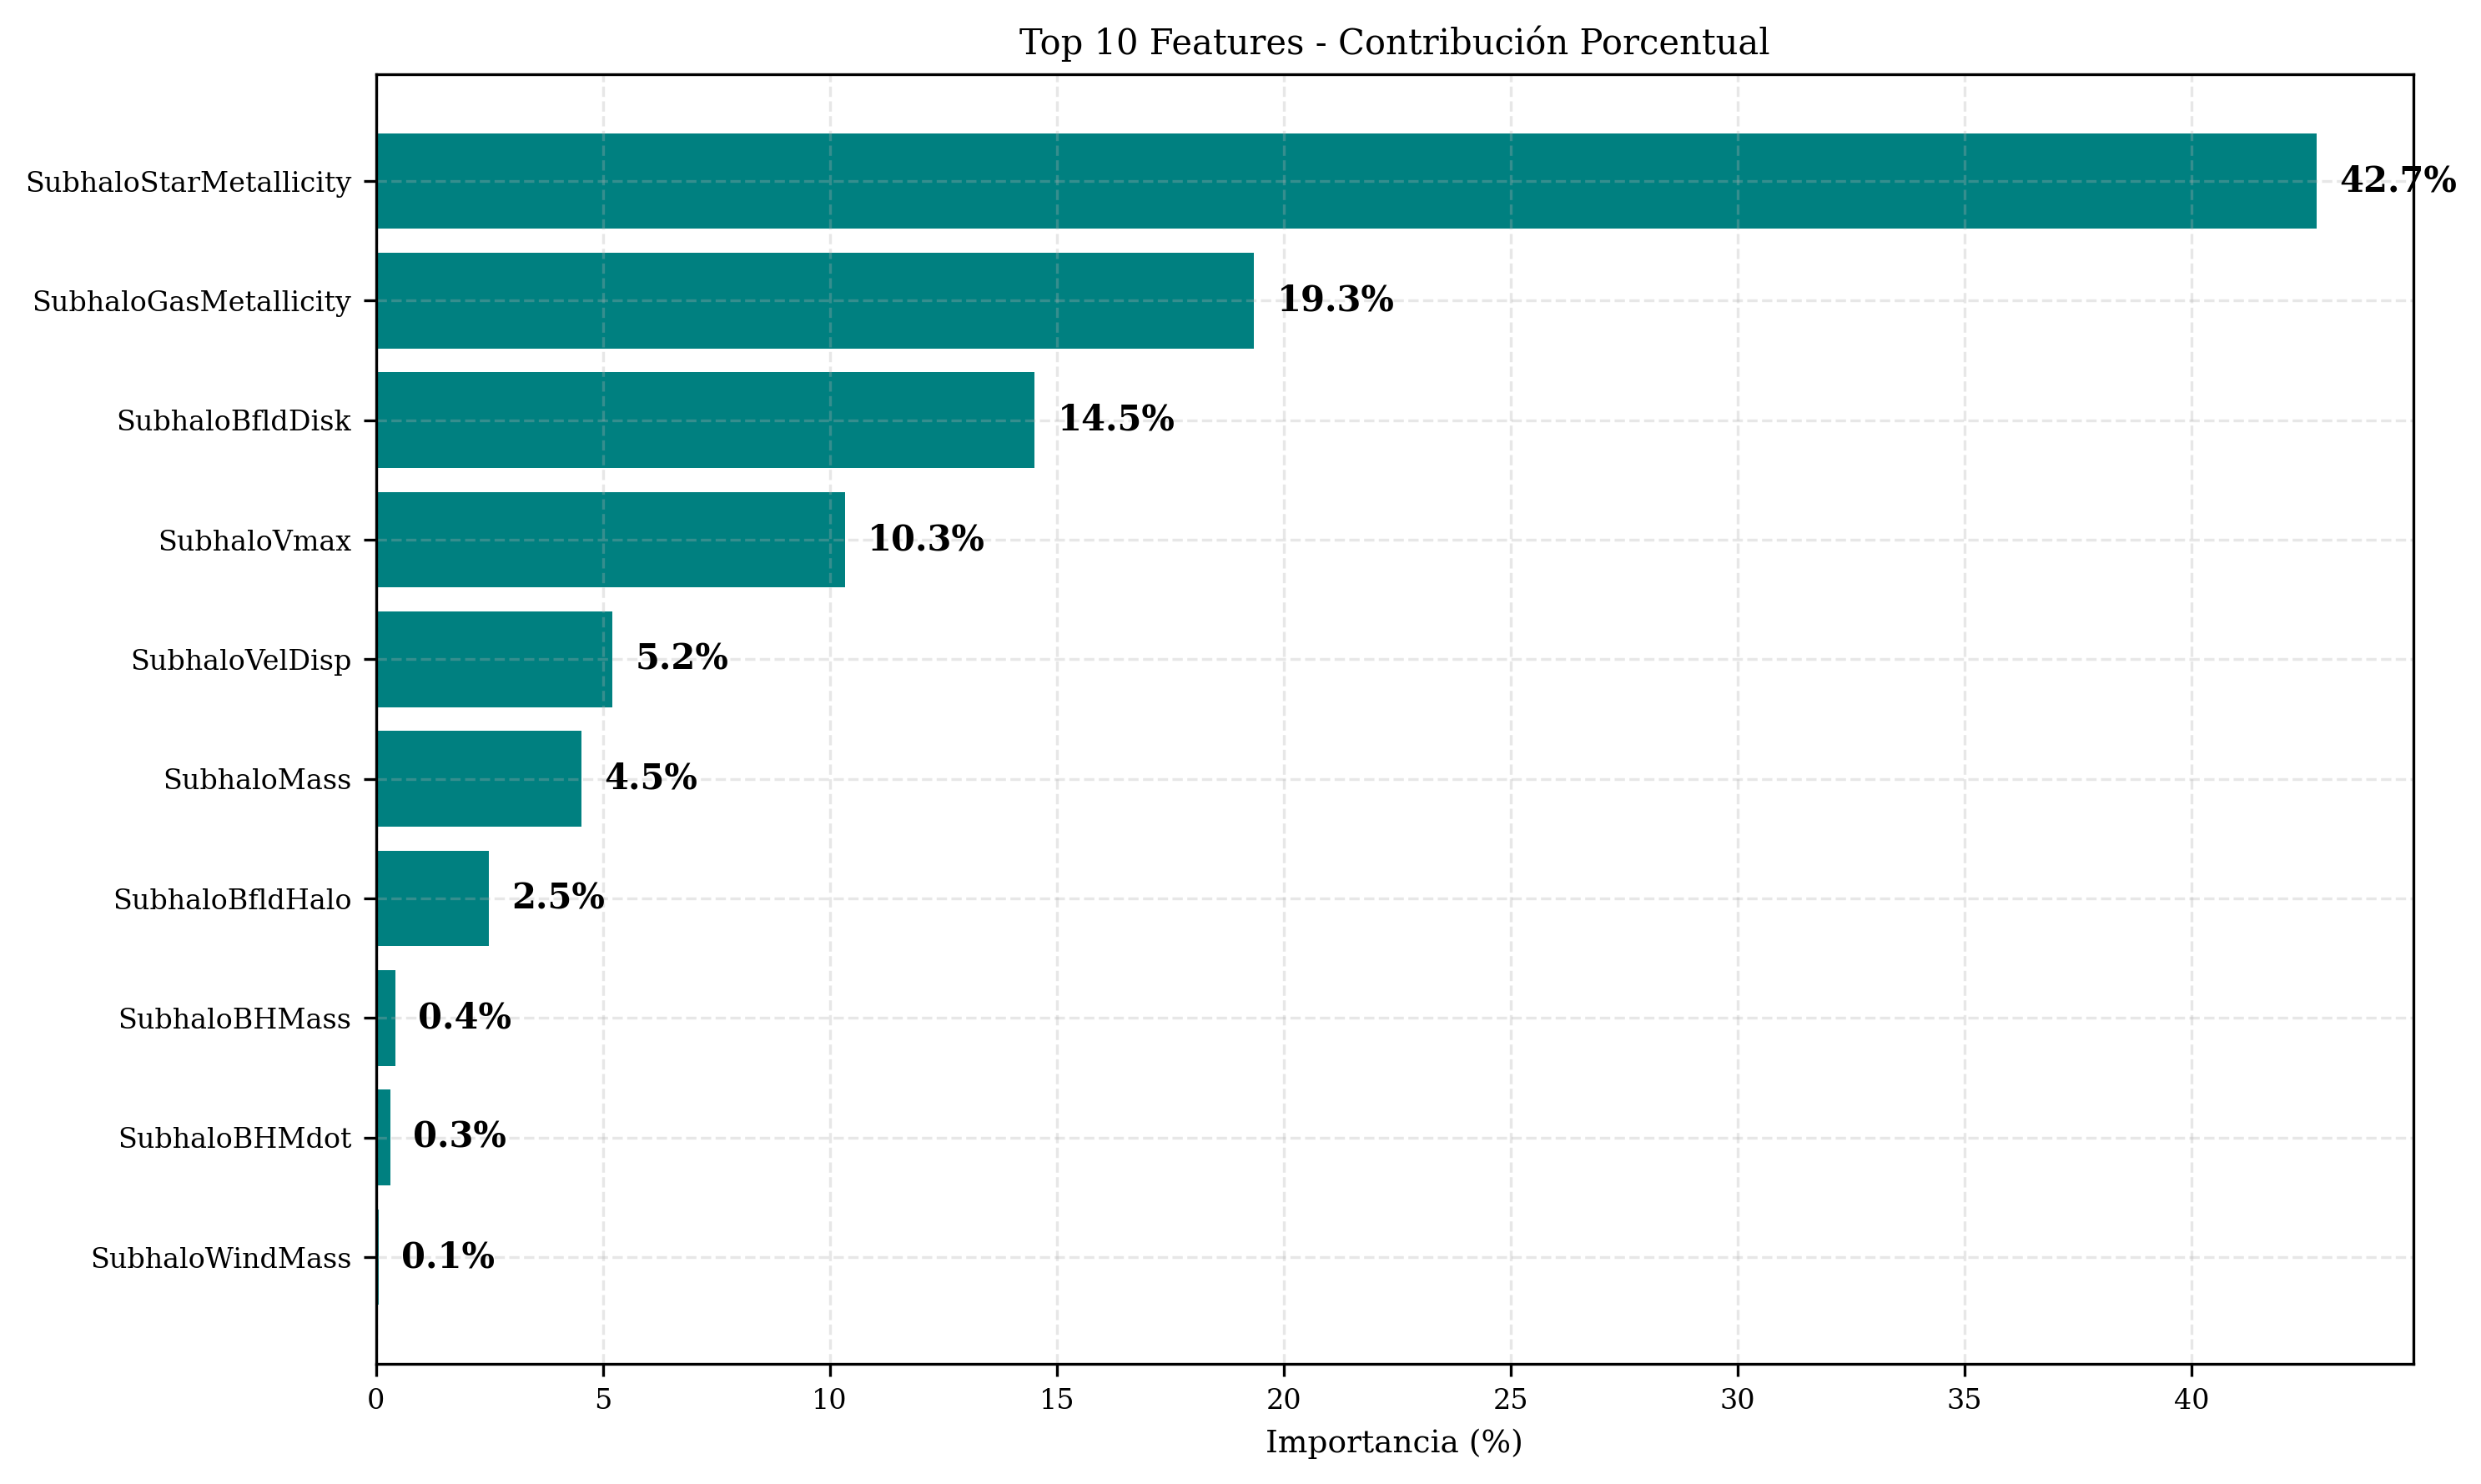

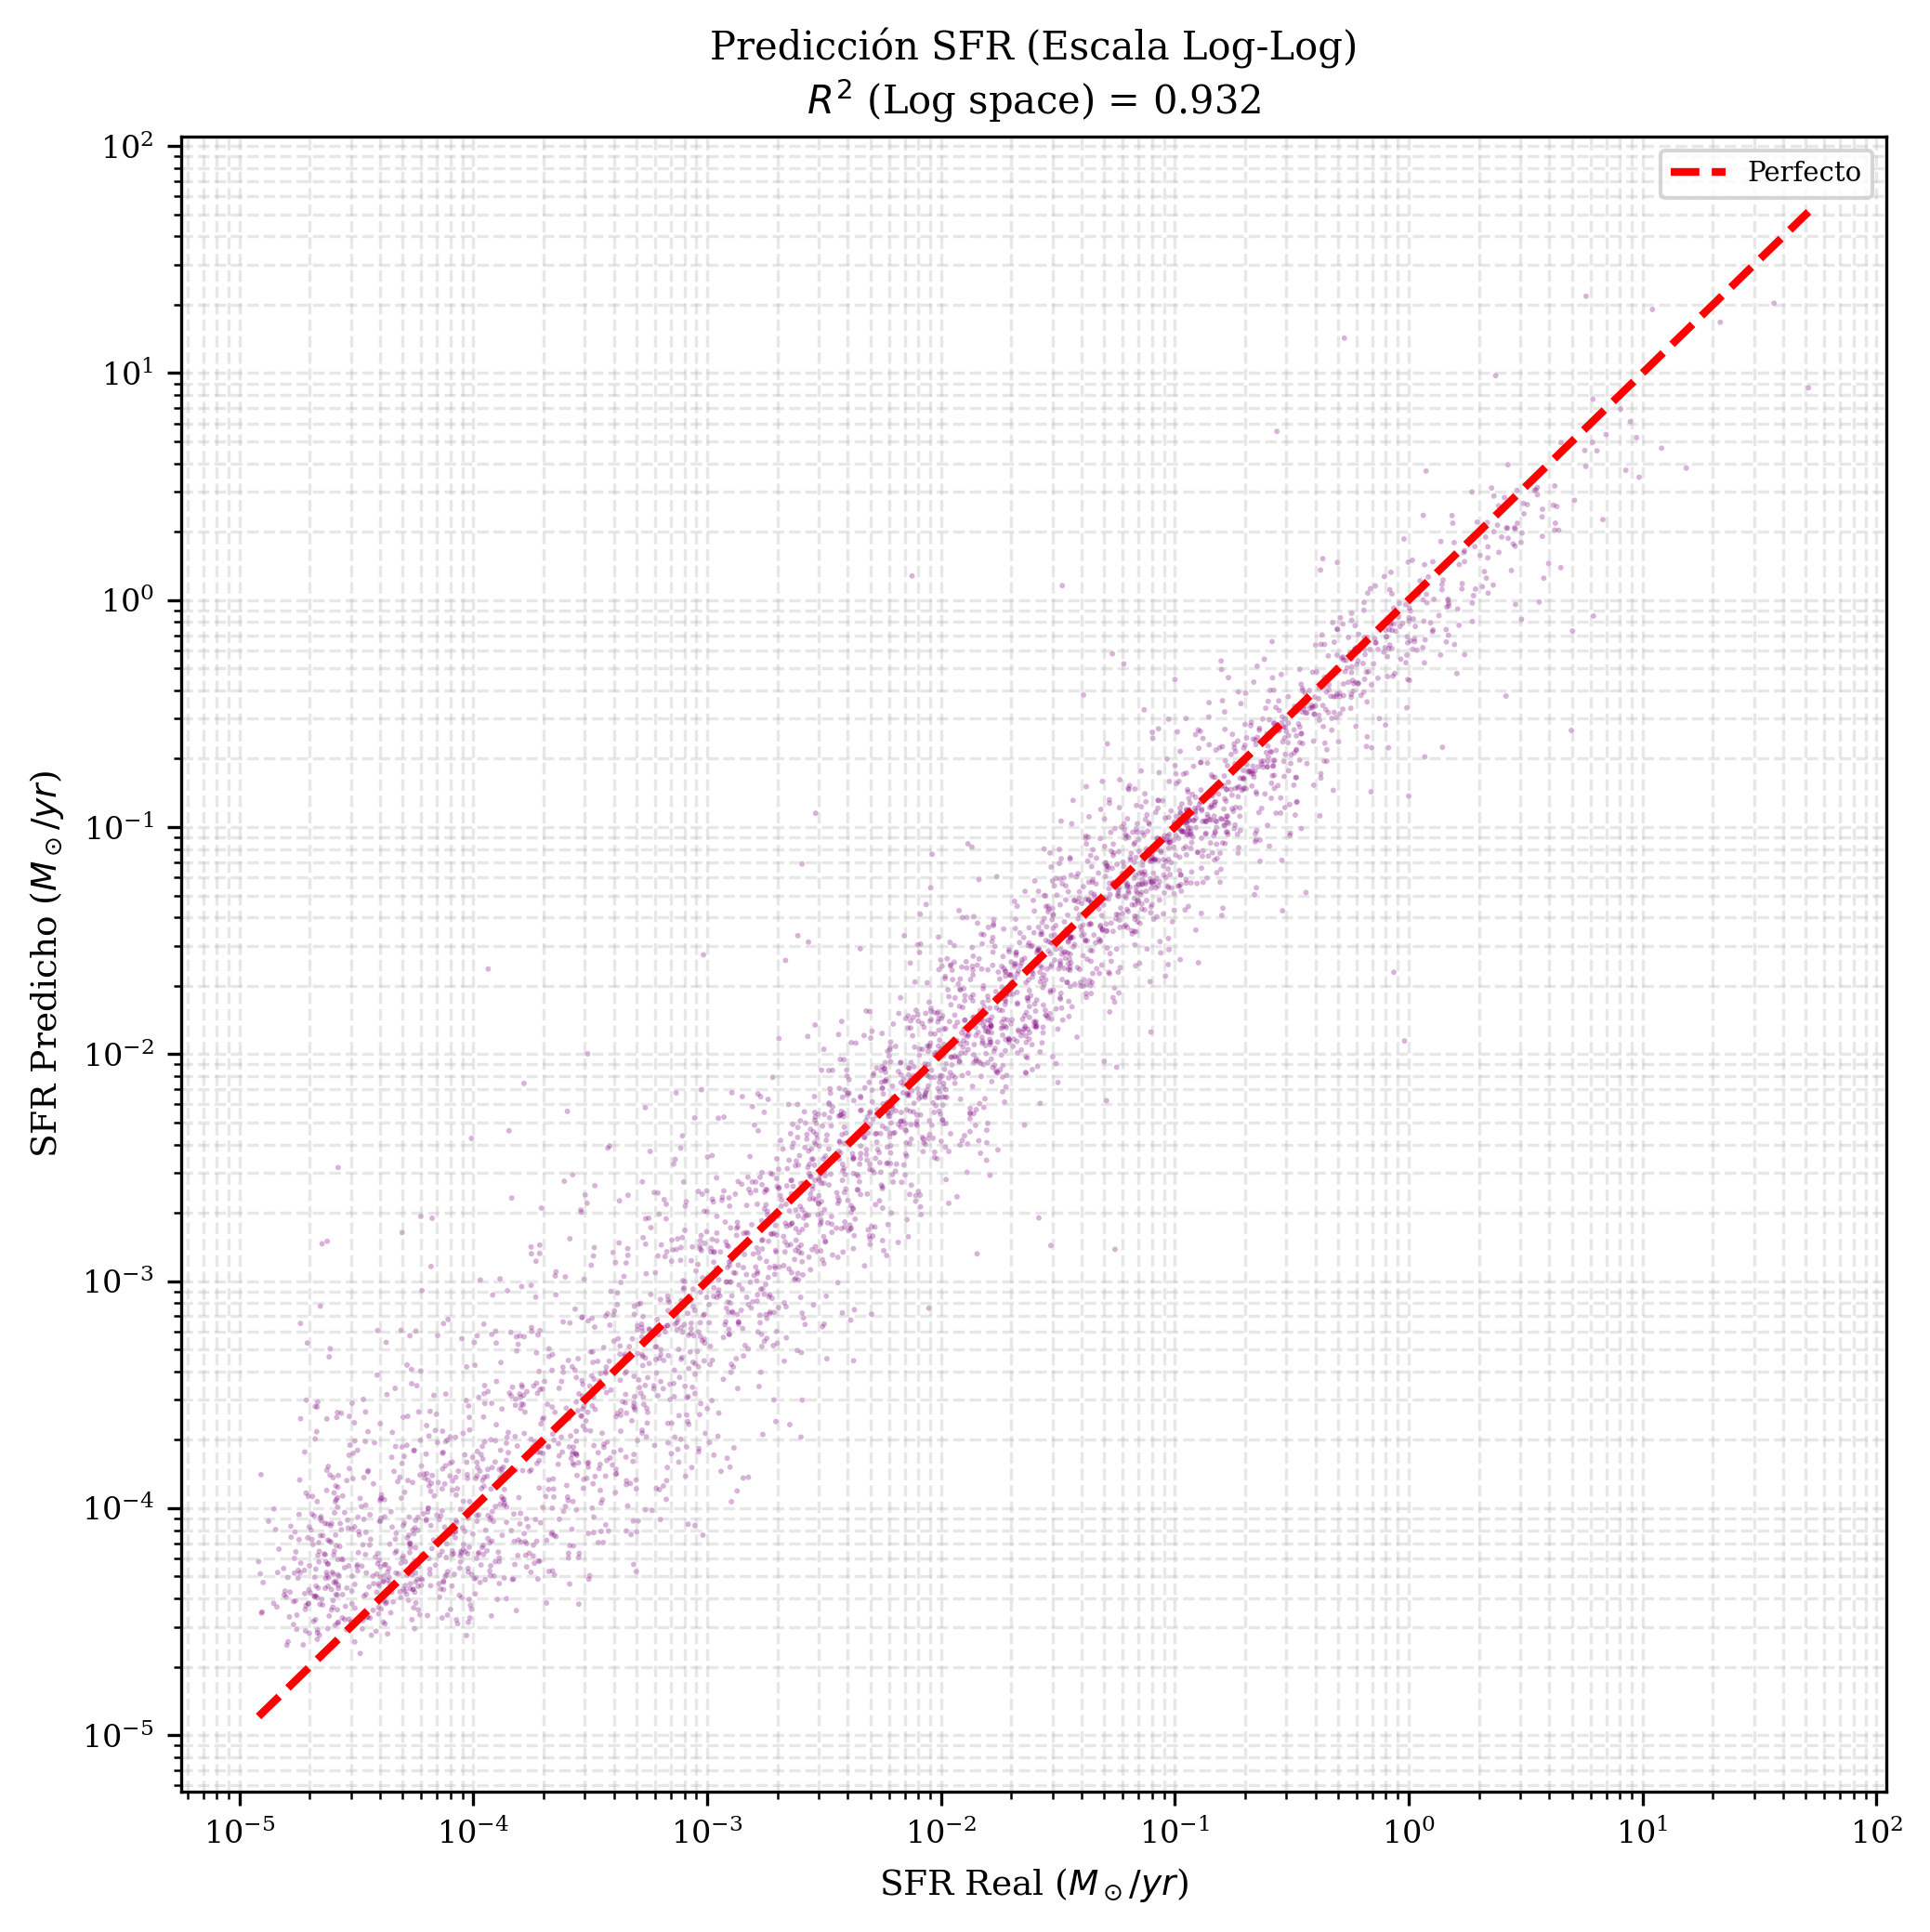

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    make_scorer,
    mean_absolute_error
)
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Supongamos que df ya está cargado o lo cargas aquí:
# df = pd.read_pickle("tng099_clean.pkl")

# ============================================================
# 1) LIMPIEZA Y PREPARACIÓN (Igual que tu versión anterior)
# ============================================================
print("="*60)
print("PREPARACIÓN DE DATOS")
print("="*60)

df_reg = df.copy()

# A. Eliminar columnas RAD y SFR (Leakage)
cols_to_drop = [c for c in df_reg.columns if ('rad' in c.lower()) or ('sfr' in c.lower() and c != 'SubhaloSFR')]
if 'JellyfishFlag' in df_reg.columns: cols_to_drop.append('JellyfishFlag')

if len(cols_to_drop) > 0:
    print(f"Eliminando {len(cols_to_drop)} columnas (Leakage/Radios)...")
    df_reg = df_reg.drop(columns=cols_to_drop)

# B. Sampling (Solo SFR > 0)
df_active = df_reg[df_reg['SubhaloSFR'] > 0].copy()
sample_size = min(500_000, len(df_active))
df_sample = df_active.sample(n=sample_size, random_state=42)

X = df_sample.drop("SubhaloSFR", axis=1)
y = df_sample["SubhaloSFR"]

# C. Transformación Logarítmica (CRÍTICO)
skewness = y.skew()
use_log = False
if skewness > 2:
    print(f"Skewness: {skewness:.2f} -> Aplicando LOG10 a la SFR.")
    use_log = True
    y = np.log10(y) # Entrenamos con el logaritmo
else:
    print("Usando escala lineal.")

# D. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ============================================================
# 2) GRID SEARCH RÁPIDO
# ============================================================
print("\n" + "="*60)
print("ENTRENANDO MODELO (Grid Search)")
print("="*60)

# Métrica: Usamos neg_mean_squared_error sobre los datos (que ya están en log)
neg_mse = make_scorer(mean_squared_error, greater_is_better=False)

rf = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True)

param_grid = {
    "n_estimators": [150, 250],
    "max_depth": [20, 30],
    "max_features": [0.5, "sqrt"],
    "min_samples_leaf": [1, 2]
}

grid = GridSearchCV(rf, param_grid, cv=3, scoring=neg_mse, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

# ============================================================
# 3) EVALUACIÓN DE MÉTRICAS (CORRECCIÓN R2)
# ============================================================
print("\n" + "="*60)
print("EVALUACIÓN DE DESEMPEÑO")
print("="*60)

# Predicciones crudas (están en LOG si use_log=True)
y_pred_raw = best_model.predict(X_test)

# --- AQUI ESTA EL CAMBIO IMPORTANTE ---
# Calculamos R2 sobre los datos tal cual se entrenaron (LOG)
r2_log = r2_score(y_test, y_pred_raw)

# RMSE en escala LOG (dex)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_raw))

print(f"Métricas en el espacio del modelo (Logarítmico):")
print(f" -> R² (Log):  {r2_log:.4f}  <-- ESTE ES EL QUE VALE")
print(f" -> RMSE (Log): {rmse_log:.4f} dex")

# Opcional: Métricas lineales solo para referencia física
if use_log:
    y_test_lin = 10**y_test
    y_pred_lin = 10**y_pred_raw
    r2_lin = r2_score(y_test_lin, y_pred_lin)
    print(f"\n(Referencia) R² en espacio lineal: {r2_lin:.4f}")

# ============================================================
# 4) FEATURE IMPORTANCE CON PORCENTAJES
# ============================================================
print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES (%)")
print("="*60)

# Obtener importancias y convertir a porcentaje
importances = best_model.feature_importances_ * 100 
feature_names = X.columns

# Crear DataFrame para ordenar
df_imp = pd.DataFrame({'feature': feature_names, 'pct': importances})
df_imp = df_imp.sort_values('pct', ascending=False)

# Imprimir tabla textual
print(df_imp.head(10).to_string(index=False, float_format="%.2f"))

# Graficar
plt.figure(figsize=(10, 6))
top_n = 10
df_plot = df_imp.head(top_n)

# Barplot
bars = plt.barh(range(top_n), df_plot['pct'], color='teal')
plt.yticks(range(top_n), df_plot['feature'])
plt.gca().invert_yaxis() # La más importante arriba

# Poner los numeritos (%) al lado de cada barra
for i, (pct, bar) in enumerate(zip(df_plot['pct'], bars)):
    plt.text(pct + 0.5, i, f"{pct:.1f}%", va='center', fontsize=10, fontweight='bold')

plt.xlabel('Importancia (%)')
plt.title(f'Top {top_n} Features - Contribución Porcentual')
plt.tight_layout()
plt.show()

# ============================================================
# 5) PLOT REAL VS PREDICHO (LOG SCATTER)
# ============================================================
plt.figure(figsize=(7, 7))

# Para el scatter usamos los valores lineales para que los ejes tengan sentido físico,
# PERO usamos escala logarítmica en los ejes.
y_real_phys = 10**y_test if use_log else y_test
y_pred_phys = 10**y_pred_raw if use_log else y_pred_raw

plt.scatter(y_real_phys, y_pred_phys, s=2, alpha=0.3, c='purple')

# Línea de identidad
vmin = min(y_real_phys.min(), y_pred_phys.min())
vmax = max(y_real_phys.max(), y_pred_phys.max())
plt.plot([vmin, vmax], [vmin, vmax], "r--", lw=2, label='Perfecto')

# Etiquetas
plt.xlabel(r'SFR Real ($M_\odot/yr$)')
plt.ylabel(r'SFR Predicho ($M_\odot/yr$)')
# Aquí ponemos el R2 Log que es el correcto para esta visualización
plt.title(f'Predicción SFR (Escala Log-Log)\n$R^2$ (Log space) = {r2_log:.3f}')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()